In [1]:
from datasets import load_dataset
from huggingface_hub import login
import tiktoken
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.stats.proportion as smp
from concurrent.futures import ProcessPoolExecutor
from scipy import stats

/Users/melinajingtinglaimon/Documents/UCL-ML-Coursework/COMP0258/stream-of-search/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def safe_convert_to_float(value):
    """
    Safely convert a value to float, handling various formats.
    
    Args:
        value: Value to convert (string, int, float, etc.)
        
    Returns:
        float: Converted value or NaN if conversion fails
    """
    if value is None:
        return float('nan')
    
    if isinstance(value, (int, float)):
        return float(value)
    
    if isinstance(value, str):
        # Clean up the string if it has ellipsis or other non-numeric characters
        clean_value = value.strip()
        
        # Handle ellipsis
        if '...' in clean_value:
            clean_value = clean_value.split('...')[0]
        
        # Remove trailing decimal point if present
        if clean_value.endswith('.'):
            clean_value = clean_value[:-1]
        
        # Handle potential multiple decimal points (like "10.4.")
        parts = clean_value.split('.')
        if len(parts) > 2:
            clean_value = parts[0] + '.' + parts[1]
        
        try:
            return float(clean_value)
        except ValueError:
            print(f"Warning: Could not convert '{value}' to float. Using NaN instead.")
            return float('nan')
    
    print(f"Warning: Unexpected type {type(value)} for value {value}. Using NaN instead.")
    return float('nan')

def get_nodes(completion):
    result = {
        'nodes': [],
        'states': []
    }

    # Format 1: "Generated Node #(id): (target):[nums]" (original format)
    node_pattern1 = re.compile(r"Generated Node #([\d,\.]+): \d+:\[([\d, ]+)\]")
    for match in node_pattern1.finditer(completion):
        result['nodes'].append({
            'node_id': match.group(1),
            'available_nums': [int(n.strip()) for n in match.group(2).split(',') if n.strip()]
        })
    
    # Format 2: "Generated Node #(id): [nums] from Operation: operation" (new format)
    node_pattern2 = re.compile(r"Generated Node #(\d+): \[([\d, ]+)\]")
    for match in node_pattern2.finditer(completion):
        result['nodes'].append({
            'node_id': match.group(1),
            'available_nums': [int(n.strip()) for n in match.group(2).split(',') if n.strip()]
        })
    
    # Format 3: "Resulting numbers: [num]" (single number in list)
    single_num_pattern = re.compile(r"Resulting Numbers?: \[(\d+)\]", re.IGNORECASE)
    for match in single_num_pattern.finditer(completion):
        result['nodes'].append({
            'node_id': None,
            'available_nums': [int(match.group(1))]
        })
    
    return result


def evaluate_and_characterize_failures(trajectory, target, nums, tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")) -> dict:
    """
    Evaluates a countdown task trajectory and returns detailed diagnosis information
    for all error types, plus equation statistics.
    
    Args:
        trajectory (str): The reasoning trajectory text
        target (int/float): The target number to reach
        nums (list): List of starting numbers available
    
    Returns:
        dict: Results containing various error indicators and statistics
    """
    import re
    import ast
    import math
    from typing import List

    # Initialize error flags
    is_valid = True
    arithmetic_error = False
    sign_error = False
    invalid_number_usage = False
    formatting_issues = False
    mismatched_target = False
    no_solution = False
    token_count = len(tokenizer(trajectory)["input_ids"])
    
    # Initialize equation counters
    total_equations = 0
    arithmetic_error_count = 0
    sign_error_count = 0
    
    # Initialize heuristic calculation tracking
    heuristic_calculation_count = 0
    heuristic_arithmetic_errors = 0
    
    # Initialize node tracking
    nodes = get_nodes(trajectory)
    num_nodes = len(nodes['nodes'])
    
    # Enhanced pattern to capture both "=" and "is" as equation separators with flexible spacing
    equation_pattern = re.compile(r"([\d.]+)(?:\.{3})?\s*([\+\-\*/])\s*([\d.]+)(?:\.{3})?\s*(?:=|is)\s*([\d.]+)(?:\.{3})?")
    all_equations = equation_pattern.findall(trajectory)
    
    total_equations = len(all_equations)
    
    # Check each equation for arithmetic correctness and sign errors
    for eq in all_equations:
        try:
            num1 = safe_convert_to_float(eq[0])
            op = eq[1]
            num2 = safe_convert_to_float(eq[2])
            result = safe_convert_to_float(eq[3])
            
            # Calculate the expected result
            if op == '+':
                expected = num1 + num2
            elif op == '-':
                expected = num1 - num2
            elif op == '*':
                expected = num1 * num2
            elif op == '/':
                if math.isclose(num2, 0.0):
                    arithmetic_error_count += 1
                    continue
                expected = num1 / num2
            else:
                # Invalid operator
                continue
                
            # Compare expected vs. given result
            if not math.isclose(expected, result, rel_tol=1e-5):
                arithmetic_error_count += 1
                
                # Check for sign error (same absolute value but wrong sign)
                if math.isclose(abs(expected), abs(result), rel_tol=1e-5) and math.copysign(1, expected) != math.copysign(1, result):
                    sign_error_count += 1
                
        except Exception:
            # Skip equations with parsing issues
            continue
    
    
    
    # Find and validate heuristic score calculations
    # Pattern for simple heuristic count
    heuristic_pattern = re.compile(r"Heuristic score\s*:", re.IGNORECASE)
    heuristic_lines = [m.start() for m in re.finditer(heuristic_pattern, trajectory)]
    heuristic_calculation_count = len(heuristic_lines)
    
    # Detailed pattern for validating the arithmetic in heuristic calculations
    # This is complex and may need tuning based on actual format
    heuristic_calc_pattern = re.compile(
        r"Heuristic score\s*:\s*\((.*?)\)/(\d+)\s*=\s*(.*?)\s*=\s*([\d.]+)", 
        re.IGNORECASE
    )
    
    for match in heuristic_calc_pattern.finditer(trajectory):
        # Extract the parts of the calculation
        expressions_part = match.group(1)  # e.g. "|9-20| + |67-20| + |57-20|"
        divisor = int(match.group(2))      # e.g. 3
        sums_part = match.group(3)         # e.g. "(11 + 47 + 37)"
        claimed_result = safe_convert_to_float(match.group(4))  # e.g. 30.33
        
        # Find individual absolute values in the expression
        abs_values = []
        try:
            # Extract values from sums part (e.g. "11 + 47 + 37")
            terms = re.findall(r'(\d+(?:\.\d+)?)', sums_part)
            abs_values = [safe_convert_to_float(t) for t in terms]
            
            # Calculate expected result
            expected_sum = sum(abs_values)
            expected_result = expected_sum / divisor
            
            # Compare with claimed result
            if not math.isclose(expected_result, claimed_result, rel_tol=1e-2):
                heuristic_arithmetic_errors += 1
        except:
            # If we can't fully parse the heuristic calculation, just count it
            pass
    
    
    # Check for formatting: SOLUTION field
    sol_match = re.search(r"SOLUTION:\s*(YES|NO)", trajectory, re.IGNORECASE)
    if not sol_match:
        formatting_issues = True
        is_valid = False
    else:
        sol_decl = sol_match.group(1).upper()
        no_solution = (sol_decl == "NO")
    
    # Extract OPERATIONS list
    operations = []
    ops_match = re.search(r"OPERATIONS:\s*(\[[^\]]*\])", trajectory, re.DOTALL)
    if not ops_match:
        formatting_issues = True
        is_valid = False
    else:
        try:
            operations = ast.literal_eval(ops_match.group(1))
            if not isinstance(operations, list):
                formatting_issues = True
                is_valid = False
        except Exception:
            formatting_issues = True
            is_valid = False    
    
    # Extract final RESULT
    expected_final = None
    res_match = re.search(r"RESULT:\s*([-+.\d]+|None)", trajectory)  # Added 'None' as a valid pattern
    if not res_match:
        formatting_issues = True
        is_valid = False
    else:
        result_str = res_match.group(1)
        if result_str.lower() == "none":
            # This is fine for NO solution cases
            if not no_solution:
                formatting_issues = True  # Only a formatting issue if SOLUTION isn't NO
        else:
            try:
                expected_final = safe_convert_to_float(result_str)
            except Exception:
                formatting_issues = True
                is_valid = False
    
    # Validate consistency between SOLUTION and OPERATIONS/RESULT
    if no_solution:
        # For NO solution: operations should be empty and result should be None
        if operations and operations != []:
            formatting_issues = True  # Having operations with NO solution is a formatting issue
        if expected_final is not None:
            formatting_issues = True  # Having a numeric result with NO solution is a formatting issue
    
    # If we have severe formatting issues, we can't proceed with arithmetic and usage checks
    if formatting_issues or no_solution:
        return {
            # Overall trajectory status
            "is_valid": is_valid,
            "no_solution": no_solution,
            
            # Main error types
            "formatting_issues": formatting_issues,
            "arithmetic_error": arithmetic_error,
            "sign_error": sign_error,
            "invalid_number_usage": invalid_number_usage,
            "mismatched_target": mismatched_target,
            
            # Error counts and statistics
            "arithmetic_error_count": arithmetic_error_count,
            "sign_error_count": sign_error_count,
            "total_equations": total_equations,
            
            # Search process metrics
            "num_nodes": num_nodes,
            "heuristic_calculation_count": heuristic_calculation_count,
            "heuristic_arithmetic_errors": heuristic_arithmetic_errors,
            
            # Resource usage
            "token_count": token_count
        }
    
    # Simulation: available numbers (as floats)
    available = [safe_convert_to_float(n) for n in nums]
    
    # Enhanced operation pattern for validation
    op_pattern = re.compile(r"^\s*([\d.]+(?:\.{3})?)\s*([\+\-\*/])\s*([\d.]+(?:\.{3})?)\s*(?:=|is)\s*([\d.]+(?:\.{3})?)\s*$")
    
    operation_results = []  # Store results to check if all numbers were used
    
    for op_str in operations:
        m = op_pattern.match(op_str)
        if not m:
            formatting_issues = True
            is_valid = False
            continue
        
        op1_str, operator, op2_str, given_result_str = m.groups()
        try:
            op1 = safe_convert_to_float(op1_str)
            op2 = safe_convert_to_float(op2_str)
            op_result = safe_convert_to_float(given_result_str)
        except Exception:
            formatting_issues = True
            is_valid = False
            continue
        
        # Check arithmetic correctness
        try:
            if operator == '+':
                computed = op1 + op2
            elif operator == '-':
                computed = op1 - op2
            elif operator == '*':
                computed = op1 * op2
            elif operator == '/':
                if math.isclose(op2, 0.0):
                    arithmetic_error = True
                    is_valid = False
                    continue
                computed = op1 / op2
            else:
                formatting_issues = True
                is_valid = False
                continue
                
            if not math.isclose(computed, op_result, rel_tol=1e-5):
                arithmetic_error = True
                is_valid = False
                
                # Check for sign error (same absolute value but wrong sign)
                if math.isclose(abs(computed), abs(op_result), rel_tol=1e-5):
                    sign_error_count += 1
                    sign_error = True
        except Exception:
            arithmetic_error = True
            is_valid = False
            continue
        
        operation_results.append((op1, op2, op_result))
    
    # Check for invalid number usage by simulating all operations
    if operation_results:
        try:
            # Reset available numbers for a fresh check
            available = [safe_convert_to_float(n) for n in nums]
            
            def consume(value, pool):
                for i, num in enumerate(pool):
                    if math.isclose(num, value, rel_tol=1e-5):
                        del pool[i]
                        return True
                return False
            
            for op1, op2, result in operation_results:
                if not consume(op1, available):
                    invalid_number_usage = True
                    is_valid = False
                    break
                
                if not consume(op2, available):
                    invalid_number_usage = True
                    is_valid = False
                    break
                
                available.append(result)
            
            # After all operations, should have exactly one number equal to target
            if len(available) != 1:
                invalid_number_usage = True
                is_valid = False
            elif expected_final is not None and not math.isclose(available[0], safe_convert_to_float(target), rel_tol=1e-5):
                mismatched_target = True
                is_valid = False
                
        except Exception:
            invalid_number_usage = True
            is_valid = False
    
    return {
            # Overall trajectory status
            "is_valid": is_valid,
            "no_solution": no_solution,
            
            # Main error types
            "formatting_issues": formatting_issues,
            "arithmetic_error": arithmetic_error,
            "sign_error": sign_error,
            "invalid_number_usage": invalid_number_usage,
            "mismatched_target": mismatched_target,
            
            # Error counts and statistics
            "arithmetic_error_count": arithmetic_error_count,
            "sign_error_count": sign_error_count,
            "total_equations": total_equations,
            
            # Search process metrics
            "num_nodes": num_nodes,
            "heuristic_calculation_count": heuristic_calculation_count,
            "heuristic_arithmetic_errors": heuristic_arithmetic_errors,
            
            # Resource usage
            "token_count": token_count
        }

In [15]:
from glob import glob
import os 
import json 
import re 

def parse_model_filepath(filepath):
    """
    Parse a model filepath to extract model size, dataset type, context length, and dataset size.
    
    Args:
        filepath (str): Path to the model file
        
    Returns:
        dict: Dictionary containing model_size, dataset_type, context_length, and dataset_size
    """
    # Extract the directory part of the path
    directory = os.path.dirname(filepath)
    # Get the last part of the directory path (the model folder name)
    model_folder = os.path.basename(directory)
    
    # Initialize result dictionary
    result = {
        "model_size": None,
        "dataset_type": None,
        "context_length": None,
        "dataset_size": None
    }
    
    # Extract model size (e.g., 0.5B, 1.5B)
    model_size_match = re.search(r'(\d+\.\d+B)', model_folder)
    if model_size_match:
        result["model_size"] = model_size_match.group(1)
    
    # Extract dataset type (e.g., o3, search, search-react)
    # We need to handle special cases like "search-react" and "search-long"
    if "search-react-correct" in model_folder:
        result["dataset_type"] = "search-react-correct"
    elif "search-react" in model_folder:
        result["dataset_type"] = "search-react"
    elif "search-long" in model_folder:
        result["dataset_type"] = "search-long"
    elif "search" in model_folder:
        result["dataset_type"] = "search"
    elif "optimal" in model_folder:
        result["dataset_type"] = "optimal"
    elif "o3" in model_folder:
        result["dataset_type"] = "o3"
    elif "deepseek-correct" in model_folder:
        result["dataset_type"] = "deepseek-correct"
    elif "deepseek" in model_folder:
        result["dataset_type"] = "deepseek"
    
    # Extract context length (e.g., 8k from seq8k)
    context_match = re.search(r'seq(\d+k)', model_folder)
    if context_match:
        result["context_length"] = context_match.group(1)
    else:
        result["context_length"] = "4k"  # Default to 4k if not found
    
    # Extract dataset size (e.g., 1k, 5k)
    # This is typically the last part of the model folder name
    dataset_size_match = re.search(r'(\d+k)(?:/|$)', model_folder)
    if dataset_size_match:
        result["dataset_size"] = dataset_size_match.group(1)
    
    # Determine method based on folder name using regex patterns
    methods = {
        "Baseline": r"qwen-2\.5-[01]\.5B-instruct-baseline",
        "OP": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-optimal-seq\d+k-\d+k",
        "SoS": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-seq\d+k-\d+k", 
        "RSoS": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-react-seq\d+k-\d+k", 
        "RSoS-Correct": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-react-correct-seq\d+k-\d+k", 
        "Distill": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-deepseek-correct-seq\d+k-\d+k"
    }
    
    # Find matching method pattern
    for method_name, pattern in methods.items():
        if re.search(pattern, model_folder):
            result["method"] = method_name
            break
    
    # If no method was assigned, mark as "Unknown"
    if result["method"] is None:
        result["method"] = "Unknown"
    
    return result

def find_experiment_files(base_dir, pattern="**/test_128*.json"):
    """Find all experiment result files in the given directory."""
    return glob(os.path.join(base_dir, pattern), recursive=True)

def process_trajectories_to_dataframe(file_path):
    """
    Process a single results file and convert trajectories to a pandas DataFrame
    with metadata and evaluation results.
    
    Args:
        file_path (str): Path to the JSON file
        
    Returns:
        pd.DataFrame: DataFrame with trajectories and their evaluations
    """
    try:
        # Check if file exists and is not empty
        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            print(f"Warning: {file_path} is empty or doesn't exist. Skipping.")
            return pd.DataFrame()
            
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
        except json.JSONDecodeError as e:
            print(f"Error: {file_path} contains invalid JSON. Skipping. Details: {str(e)}")
            return pd.DataFrame()
        
        # Skip the first two elements as per requirements
        if len(data) <= 2:
            print(f"Warning: {file_path} has fewer than 3 elements. Skipping.")
            return pd.DataFrame()
            
        trajectories = data[2:]  # Start from the 3rd element
        
        # Get model metadata
        model_info = parse_model_filepath(file_path)
        if model_info["method"]=="Unknown":
            print(f"Not using {file_path} in final report. Skipping.")
            return pd.DataFrame()
        
        # Process each trajectory
        trajectories_results = []
        for idx, row in enumerate(trajectories):
            try:
                # Handle type issues with safe_convert function
                result = evaluate_and_characterize_failures(
                    row.get("completion", ""),  # Use get with default values
                    row.get("target", ""),
                    row.get("nums", [])
                )
                
                # Add trajectory data and model metadata
                result["trajectory_index"] = idx
                result["completion"] = row.get("completion", "")
                result["target"] = row.get("target", "")
                result["nums"] = row.get("nums", [])
                result["file_path"] = file_path
                
                # Add model metadata
                for key, value in model_info.items():
                    result[key] = value
                    
                trajectories_results.append(result)
            except Exception as e:
                print(f"Error processing trajectory {idx} in {file_path}: {str(e)}")
                # Continue with next trajectory instead of failing the whole file
        
        return pd.DataFrame(trajectories_results)
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return pd.DataFrame()


def process_json_files(base_dir):
    """
    Find and process all experiment result files, returning both individual trajectories
    and aggregate statistics.
    
    Args:
        base_dir (str): Base directory to search for experiment files
        
    Returns:
        tuple: (trajectory_df, stats_df) where:
            - trajectory_df: DataFrame with each trajectory and its evaluation
            - stats_df: DataFrame with aggregate statistics for each model
    """
    # Find all test_*.json files
    test_files = find_experiment_files(base_dir)
    
    # Process each file to get individual trajectories
    all_trajectories = []
    for file_path in tqdm(test_files):
        df = process_trajectories_to_dataframe(file_path)
        all_trajectories.append(df)
    
    # Combine all trajectories
    if all_trajectories:
        trajectory_df = pd.concat(all_trajectories, ignore_index=True)
    else:
        trajectory_df = pd.DataFrame()
    
    # Calculate aggregate statistics per file/model
    stats_results = []
    # Group by file path to calculate stats
    if not trajectory_df.empty:
        for file_path, file_df in trajectory_df.groupby("file_path"):
            # Get model info once (same for all rows in this group)
            model_info = {
                "model_size": file_df["model_size"].iloc[0],
                "dataset_type": file_df["dataset_type"].iloc[0],
                "context_length": file_df["context_length"].iloc[0],
                "dataset_size": file_df["dataset_size"].iloc[0],
                "folder": file_path.split("/")[-2],
            }
            
            # Calculate statistics
            total_rows = len(file_df)
            max_tokens = file_df["token_count"].max()
            
            # Get counts of various issues
            total_is_valid = file_df["is_valid"].sum()
            total_has_arithmetic_error = file_df["arithmetic_error"].sum()
            total_has_sign_error = file_df["sign_error"].sum()
            total_has_mismatched_target = file_df["mismatched_target"].sum()
            total_has_invalid_number = file_df["invalid_number_usage"].sum()
            total_has_formatting_issues = file_df["formatting_issues"].sum()
            total_has_no_solution = file_df["no_solution"].sum()

            # Calculate incomplete trajectories
            max_token_count_occurrences = (file_df["token_count"] == max_tokens).sum()
            total_has_formatting_issues_and_reach_max_tokens = 0

            if (max_token_count_occurrences >= 2) or (max_tokens in [ 8333,  8331, 10141, 16525,  8334]):
                # Only count incomplete trajectories if we have at least 2 trajectories with max token count
                total_has_formatting_issues_and_reach_max_tokens = ((file_df["formatting_issues"]) & 
                                                            np.isclose(file_df["token_count"],max_tokens, rtol=1e-2)).sum()
                total_has_formatting_issues = ((file_df["formatting_issues"]) & 
                                                    (np.isclose(file_df["token_count"],max_tokens, rtol=1e-2)==False)).sum()

            # Calculate percentage of arithmetic errors per trajectory
            arithmetic_error_percentages = []
            for _, row in file_df.iterrows():
                if row["total_equations"] > 0:
                    error_percentage = row["arithmetic_error_count"] / row["total_equations"]
                    arithmetic_error_percentages.append(error_percentage)
                else:
                    arithmetic_error_percentages.append(0.0)

            # Calculate mean percentage of arithmetic errors
            mean_percentage_arithmetic_error = 0
            if arithmetic_error_percentages:
                mean_percentage_arithmetic_error = sum(arithmetic_error_percentages) / len(arithmetic_error_percentages)
            
            
            # Create statistics dictionary
            stats = model_info.copy()
            stats.update({
                "total_rows": total_rows,
                "perc_success": total_is_valid/total_rows,
                "perc_arithmetic_errors_in_answer": total_has_arithmetic_error/total_rows,
                "perc_sign_errors_in_answer": total_has_sign_error/total_rows,
                "perc_using_invalid_numbers": total_has_invalid_number/total_rows,
                "perc_mismatched_target": total_has_mismatched_target/total_rows,
                "perc_incomplete_trajectories": total_has_formatting_issues_and_reach_max_tokens/total_rows,
                "perc_formatting_issues": total_has_formatting_issues/total_rows,
                "perc_has_no_solution": total_has_no_solution/total_rows,
                "mean_perc_arithmetic_errors_in_full_trajectory": mean_percentage_arithmetic_error,
                "max_token_count_occurrences": max_token_count_occurrences/total_rows,
                "max_tokens": max_tokens,
                "mean_num_nodes": file_df["num_nodes"].mean(),
                "max_num_nodes": file_df["num_nodes"].max(),
            })
            stats_results.append(stats)
    
    # Create DataFrame from aggregated results
    stats_df = pd.DataFrame(stats_results)
    
    return trajectory_df, stats_df

In [16]:
trajectory_df, stats_df = process_json_files("results")

  3%|▎         | 1/36 [00:01<00:50,  1.46s/it]

Error processing results/qwen-2.5-0.5B-instruct-sft-lora-countdown-o3-5k/test_128_20250330-173225.json: 'method'


  8%|▊         | 3/36 [00:02<00:19,  1.69it/s]

Error processing results/qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k/no-backtrack/test_128_20250406-151041.json: 'method'
Error processing results/qwen-2.5-1.5B-instruct-sft-lora-countdown-search-1k/test_128_20250401-122421.json: 'method'


 17%|█▋        | 6/36 [00:02<00:12,  2.42it/s]

Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-sos_react-1k/test_128_20250404-183009.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-sos_react-1k/test_128_20250404-160335.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-search-react-1k/test_128_20250401-122436.json: 'method'
Error processing results/qwen-2.5-0.5B-instruct-countdown-baseline/test_128_20250404-180326.json: 'method'


 31%|███       | 11/36 [00:03<00:06,  3.99it/s]

Error processing results/qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k/test_128_20250330-164311.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-search-react-5k/test_128_20250401-132051.json: 'method'


 39%|███▉      | 14/36 [00:04<00:04,  4.57it/s]

Error processing results/qwen-2.5-0.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k/no-backtrack/test_128_20250406-133548.json: 'method'
Error processing results/qwen-2.5-0.5B-instruct-sft-lora-countdown-o3-1k/test_128_20250330-195109.json: 'method'


 47%|████▋     | 17/36 [00:16<00:27,  1.45s/it]

Error processing results/qwen-2.5-1.5B-instruct-countdown-baseline/test_128_20250405-012923.json: 'method'


 53%|█████▎    | 19/36 [00:17<00:20,  1.23s/it]

Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-1kx2/test_128_20250404-183836.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-optimal-1k/test_128_20250404-022656.json: 'method'


 67%|██████▋   | 24/36 [00:19<00:11,  1.06it/s]

Error processing results/qwen-2.5-0.5B-instruct-sft-lora-countdown-optimal-1k/test_128_20250330-235123.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-search-5k/test_128_20250401-123534.json: 'method'
Error processing results/qwen-2.5-0.5B-instruct-sft-lora-countdown-search-1k/test_128_20250331-062021.json: 'method'


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]

Error processing results/qwen-2.5-1.5B-instruct-sft-lora-countdown-search-long-1k/test_128_20250401-123936.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-1k/test_128_20250404-051432.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-1k/test_128_20250404-172737.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-sos-1k/test_128_20250404-052409.json: 'method'
Error processing results/bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-sos-1k/test_128_20250404-181510.json: 'method'
Error processing results/qwen-2.5-0.5B-instruct-sft-lora-countdown-search-react-1k/test_128_20250331-043701.json: 'method'


In [17]:
# Modify methods dict to use regex patterns instead of exact strings
methods = {
    "Baseline": r"qwen-2\.5-[01]\.5B-instruct-baseline",
    "OP": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-optimal-seq8k-5k",
    "SoS": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-seq8k-5k", 
    "RSoS": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-react-seq8k-5k", 
    "RSoS-Correct": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-react-correct-seq10k-5k", 
    "Distill": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k"
}

# Create a new column 'method' in stats_df
def get_method(folder):
    for method_name, pattern in methods.items():
        if re.match(pattern, folder):
            return method_name
    return "Unknown"  # For folders that don't match any pattern

# Add the method column
stats_df['method'] = stats_df['folder'].apply(get_method)

# Filter to show only rows that match our patterns
filtered_df = stats_df[stats_df['method'] != "Unknown"]

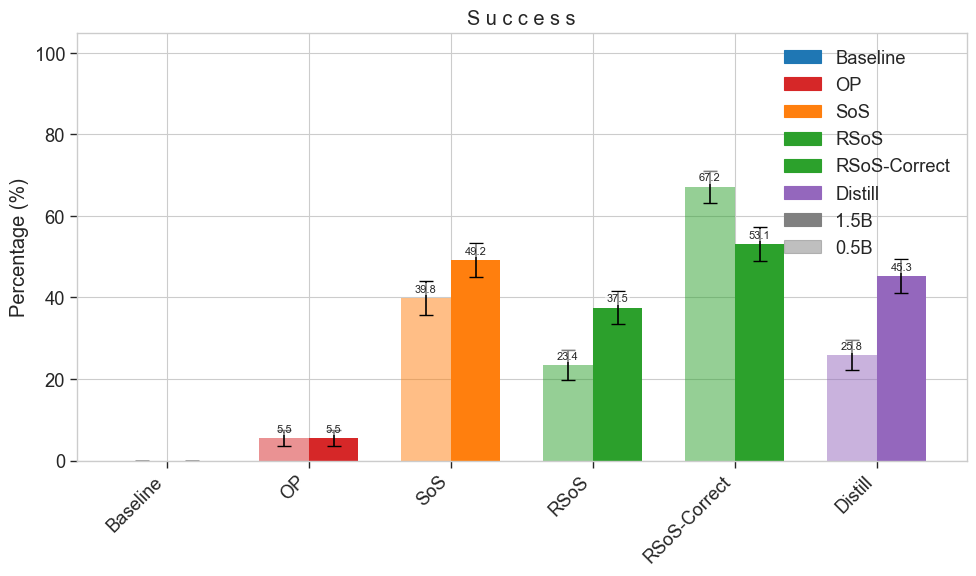

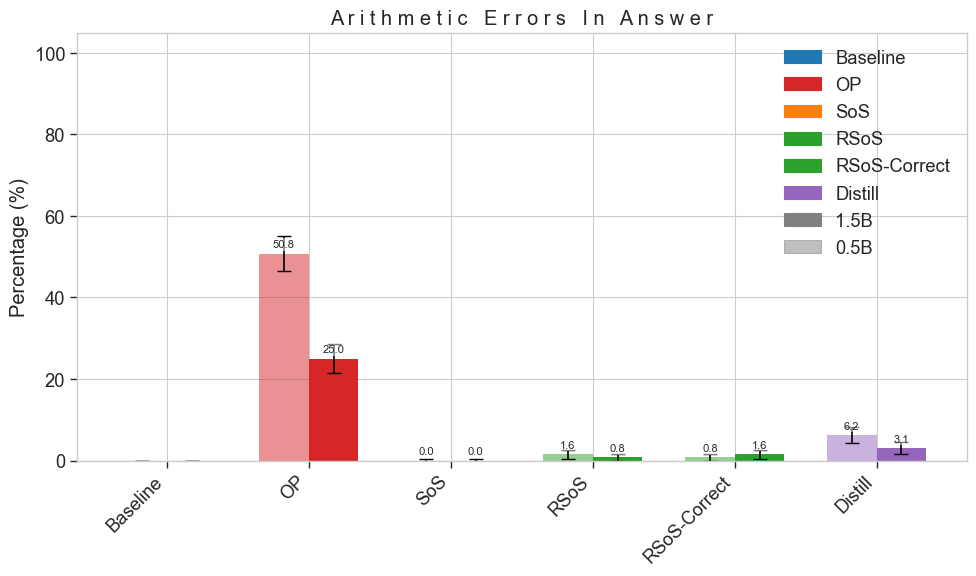

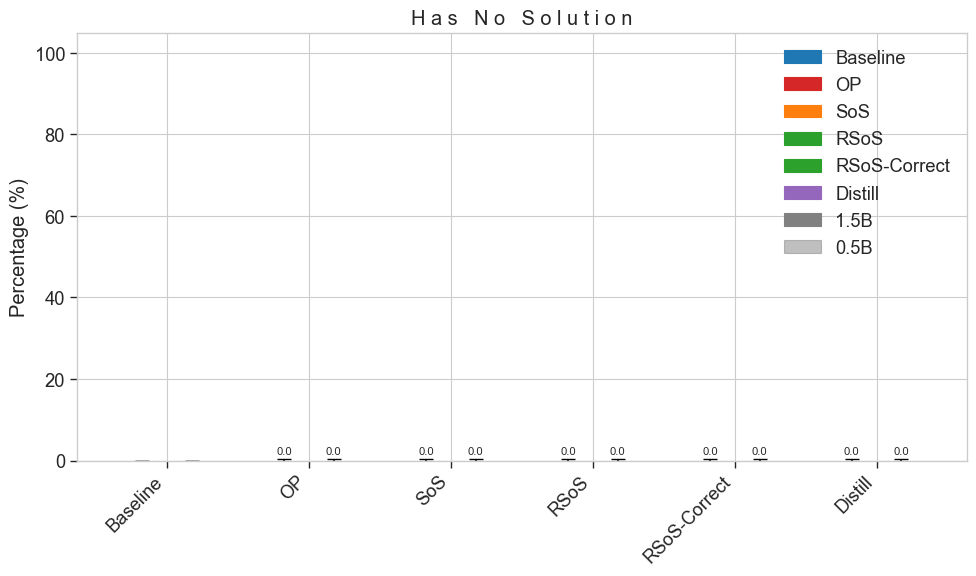

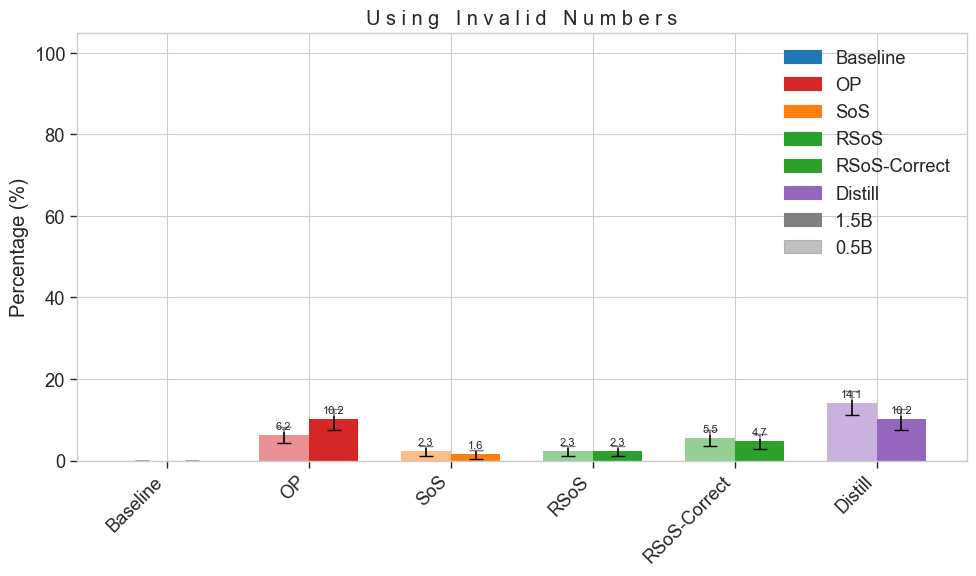

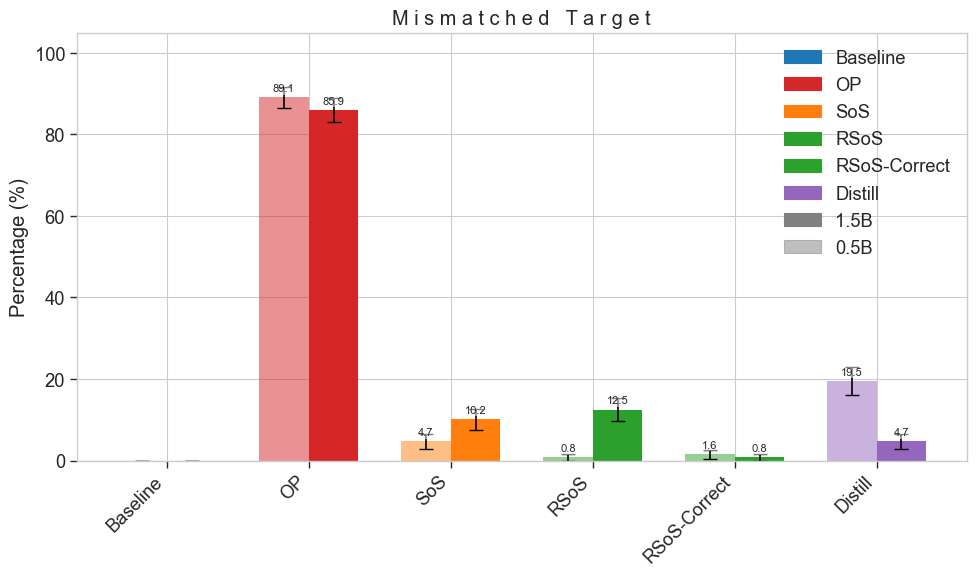

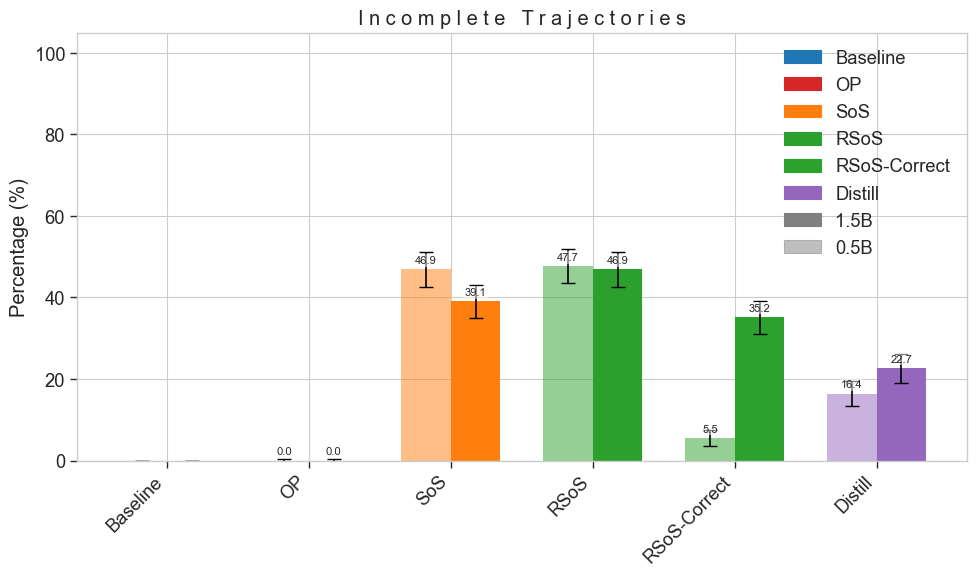

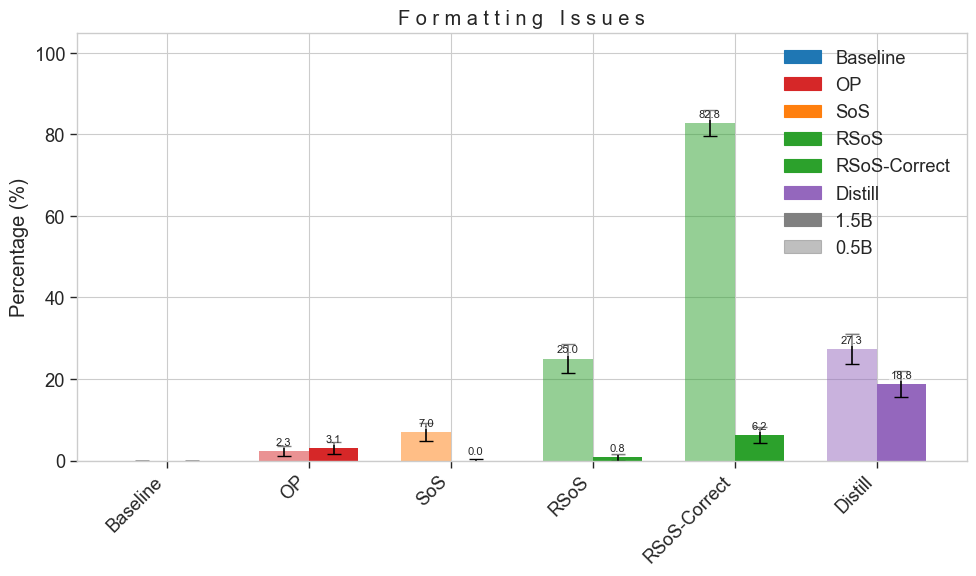

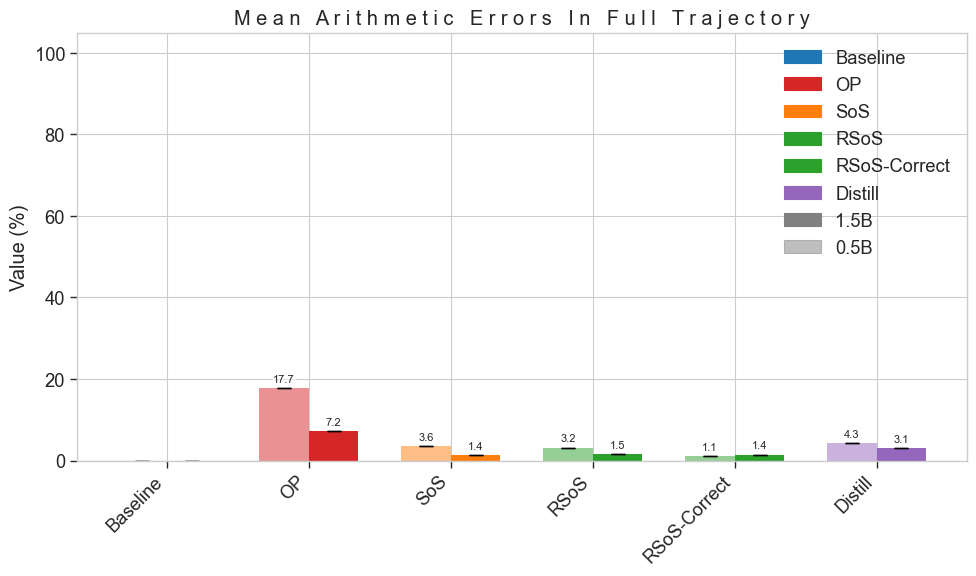

All plots saved to the 'images/' directory


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import os

# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Set style for scientific publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# List of metrics to plot
metrics = [
    'perc_success',
    'perc_arithmetic_errors_in_answer',
    # 'perc_sign_errors_in_answer',
    "perc_has_no_solution",
    'perc_using_invalid_numbers',
    'perc_mismatched_target',
    'perc_incomplete_trajectories',
    'perc_formatting_issues',
    'mean_perc_arithmetic_errors_in_full_trajectory'
]

# Define method order and colors
method_order = ['Baseline', 'OP', 'SoS', 'RSoS', 'RSoS-Correct', 'Distill']
method_colors = {
    'Baseline': '#1f77b4',  # blue
    'OP': '#d62728',        # red 
    'SoS': '#ff7f0e',       # orange
    'RSoS': '#2ca02c',      # green
    'RSoS-Correct': '#2ca12c',  # green
    'Distill': '#9467bd'    # purple
}

# Improved confidence interval calculation with capping
def binomial_ci(success, total, confidence=0.66):
    """Calculate binomial proportion confidence interval using Wilson score interval"""
    if total == 0:
        return 0
    
    # Wilson score interval (more appropriate for proportions)
    z = stats.norm.ppf(1 - (1 - confidence) / 2)  # Two-tailed z-score
    p = success / total
    
    # Calculate Wilson score interval
    denominator = 1 + z**2/total
    center = (p + z**2/(2*total)) / denominator
    margin = z * np.sqrt((p*(1-p) + z**2/(4*total)) / total) / denominator
    
    # Return just the margin of error
    return margin * 100  # Convert to percentage

# Create a plot for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set x-axis with specified order
    x = np.arange(len(method_order))
    width = 0.35  # Width of bars
    
    # Plot bars for 0.5B and 1.5B models
    for i, size in enumerate(['0.5B', '1.5B']):
        subset = filtered_df[filtered_df['model_size'] == size]
        values = []
        errors = []
        
        for method in method_order:
            method_data = subset[subset['method'] == method]
            if len(method_data) > 0:
                # Extract the metric value
                value = method_data[metric].values[0]*100
                # Calculate CI
                total = method_data['total_rows'].values[0]
                
                # For percentage metrics, convert to proportion first
                if metric.startswith('perc_'):
                    success = (value / 100) * total
                    error = binomial_ci(success, total)
                else:
                    # For mean_perc_arithmetic_errors, use standard error
                    error = 0  # You may need a different approach for this metric
                
                values.append(value)
                errors.append(error)
            else:
                values.append(0)
                errors.append(0)
        
        # Plot with appropriate color and opacity
        opacity = 0.5 if size == '0.5B' else 1.0
        for j, method in enumerate(method_order):
            if j < len(values):  # Check if we have data for this method
                ax.bar(j + (i - 0.5) * width, values[j], width, 
                      color=method_colors[method], alpha=opacity,
                      label=f'{method} {size}' if j == 0 else "", 
                      yerr=errors[j], capsize=5)
    
    # Customize the plot
    metric_name = ' '.join(metric.replace('perc_', '').replace('_', ' ').title())
    ax.set_ylabel(f'{"Percentage" if metric.startswith("perc_") else "Value"} (%)')
    ax.set_title(f'{metric_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(method_order, rotation=45, ha='right')
    
    # Ensure y-axis starts at 0 and stays within bounds for percentage metrics
    ax.set_ylim(0, 105)  # Cap at 105% for visibility
    
    # Custom legend to show both size and method correctly
    handles, labels = [], []
    # First add method colors
    for method in method_order:
        handles.append(plt.Rectangle((0,0),1,1, color=method_colors[method]))
        labels.append(method)
    # Then add size indicators
    handles.append(plt.Rectangle((0,0),1,1, color='gray', alpha=1.0))
    handles.append(plt.Rectangle((0,0),1,1, color='gray', alpha=0.5))
    labels.append('1.5B')
    labels.append('0.5B')
    
    ax.legend(handles, labels, loc='upper right', ncol=1)
    
    # Add value labels on top of bars
    for i, size in enumerate(['0.5B', '1.5B']):
        subset = filtered_df[filtered_df['model_size'] == size]
        for j, method in enumerate(method_order):
            method_data = subset[subset['method'] == method]
            if len(method_data) > 0:
                value = method_data[metric].values[0] * 100
                ax.text(j + (i - 0.5) * width, value + 1, f'{value:.1f}', 
                    ha='center', va='bottom', fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5, pad=1, edgecolor='none'))
    
    plt.tight_layout()
    
    # Create a clean filename by replacing special characters
    clean_metric_name = metric.replace('perc_', '')
    
    # Save the figure (both PDF for publication and PNG for quick viewing)
    # fig.savefig(f'images/{clean_metric_name}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    fig.savefig(f'images/{clean_metric_name}.png', format='png', dpi=150, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)

print(f"All plots saved to the 'images/' directory")

In [20]:
from scipy import stats
from statsmodels.stats import proportion
import numpy as np
import pandas as pd

def compare_methods(df, method1, method2, metric, model_size='1.5B', test_type='prop_test'):
    """
    Compute p-value for comparing two methods on a proportion metric.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the methods and metrics
    method1, method2 : str
        Names of the methods to compare
    metric : str
        Name of the proportion metric to compare (should be in [0,1])
    model_size : str, optional
        Model size to filter by (default: '1.5B')
    test_type : str, optional
        Type of statistical test: 'prop_test' (default) or 'fisher_exact'
        
    Returns:
    --------
    dict
        Dictionary containing p_value, test_statistic, and other relevant information
    """
    # Filter data for the two methods
    data1 = df[(df['method'] == method1) & (df['model_size'] == model_size)]
    data2 = df[(df['method'] == method2) & (df['model_size'] == model_size)]
    
    if len(data1) == 0 or len(data2) == 0:
        return {
            'error': f"Data missing for one or both methods: {method1}, {method2} with model size {model_size}",
            'p_value': None,
            'test_statistic': None
        }
    
    # Extract proportions and sample sizes
    p1 = data1[metric].values[0]  # Proportion for method 1
    p2 = data2[metric].values[0]  # Proportion for method 2
    n1 = data1['total_rows'].values[0]  # Sample size for method 1
    n2 = data2['total_rows'].values[0]  # Sample size for method 2
    
    # Calculate counts
    count1 = int(round(p1 * n1))  # Success count for method 1
    count2 = int(round(p2 * n2))  # Success count for method 2
    
    # Perform the statistical test
    if test_type == 'prop_test':
        # Two-proportion z-test
        count = np.array([count1, count2])
        nobs = np.array([n1, n2])
        
        # Calculate the z statistic and p-value
        stat, p_value = proportion.proportions_ztest(count, nobs)
        
        return {
            'method1': method1,
            'method2': method2,
            'metric': metric,
            'p1': p1,
            'p2': p2,
            'n1': n1,
            'n2': n2,
            'diff': p1 - p2,
            'z_stat': stat,
            'p_value': p_value,
            'significant_0.05': p_value < 0.05,
            'significant_0.01': p_value < 0.01
        }
    
    elif test_type == 'fisher_exact':
        # Fisher's exact test (for smaller sample sizes)
        table = np.array([[count1, n1 - count1], [count2, n2 - count2]])
        odds_ratio, p_value = stats.fisher_exact(table)
        
        return {
            'method1': method1,
            'method2': method2,
            'metric': metric,
            'p1': p1,
            'p2': p2,
            'n1': n1,
            'n2': n2,
            'diff': p1 - p2,
            'odds_ratio': odds_ratio,
            'p_value': p_value,
            'significant_0.05': p_value < 0.05,
            'significant_0.01': p_value < 0.01
        }
    
    else:
        return {'error': f"Unknown test type: {test_type}"}

# Example usage:
# result = compare_methods(filtered_df, 'SoS', 'Baseline', 'perc_success')
# print(f"P-value: {result['p_value']:.4f}, Significant: {result['significant_0.05']}")

# To compare multiple methods or metrics:
def compare_all_methods(df, methods, metrics, model_size='1.5B'):
    """
    Compare all pairs of methods across specified metrics.
    
    Returns a DataFrame with statistical comparison results.
    """
    results = []
    
    for metric in metrics:
        for i, method1 in enumerate(methods):
            for method2 in methods[i+1:]:  # Compare with methods that come after
                result = compare_methods(df, method1, method2, metric, model_size)
                if 'error' not in result:
                    results.append(result)
    
    return pd.DataFrame(results)

In [49]:
# Compare two specific methods on success rate
result = compare_methods(filtered_df, 'SoS', 'Baseline', 'perc_success')
print(f"P-value: {result['p_value']:.4f}")

# Compare all methods on multiple metrics
metrics_to_compare = ['perc_success', 'perc_arithmetic_errors_in_answer']
methods_to_compare = ['RSoS','RSoS-Correct']
comparison_table = compare_all_methods(filtered_df, methods_to_compare, metrics_to_compare)
comparison_table

P-value: 0.2599


,method1,method2,metric,p1,p2,n1,n2,diff,z_stat,p_value,significant_0.05,significant_0.01
0,RSoS,RSoS-Correct,perc_success,0.375000,0.531250,128,128,-0.156250,-2.511059,0.012037,True,False
1,RSoS,RSoS-Correct,perc_arithmetic_errors_in_answer,0.007812,0.015625,128,128,-0.007812,-0.580763,0.561400,False,False


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datasets import load_dataset
from tqdm import tqdm

# Set style for scientific publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# Define function to extract node counts
def count_nodes(text):
    """Count the number of nodes in a trajectory"""
    if not isinstance(text, str):
        return 0
    
    # Use your existing get_nodes function and count results
    result = get_nodes(text)
    return len(result['nodes'])


# 1. Process training dataset
print("Loading HuggingFace dataset...")
hf_dataset = load_dataset("MelinaLaimon/stream-of-search-correctness-token-length", split="train")

# Convert to pandas for easier manipulation
print("Converting to pandas DataFrame...")
train_df = pd.DataFrame(hf_dataset)

# Extract node counts for SoS-React
print("Extracting node counts from training data...")
train_df['num_nodes_optimal'] = [
    count_nodes(row['messages_optimal'][1]['content']) 
    if isinstance(row['messages_optimal'], list) and len(row['messages_optimal']) > 0 
    else 0 
    for row in tqdm(train_df.to_dict('records'))
]
train_df['num_nodes_sos'] = [
    count_nodes(row['messages_sos'][1]['content']) 
    if isinstance(row['messages_sos'], list) and len(row['messages_sos']) > 0 
    else 0 
    for row in tqdm(train_df.to_dict('records'))
]
train_df['num_nodes_sos_react'] = [
    count_nodes(row['messages_sos_react'][1]['content']) 
    if isinstance(row['messages_sos_react'], list) and len(row['messages_sos_react']) > 0 
    else 0 
    for row in tqdm(train_df.to_dict('records'))
]

Loading HuggingFace dataset...
Converting to pandas DataFrame...
Extracting node counts from training data...


100%|██████████| 10000/10000 [00:02<00:00, 4557.02it/s]


/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/1082540559.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/1082540559.py:143: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/1082540559.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/1082540559.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

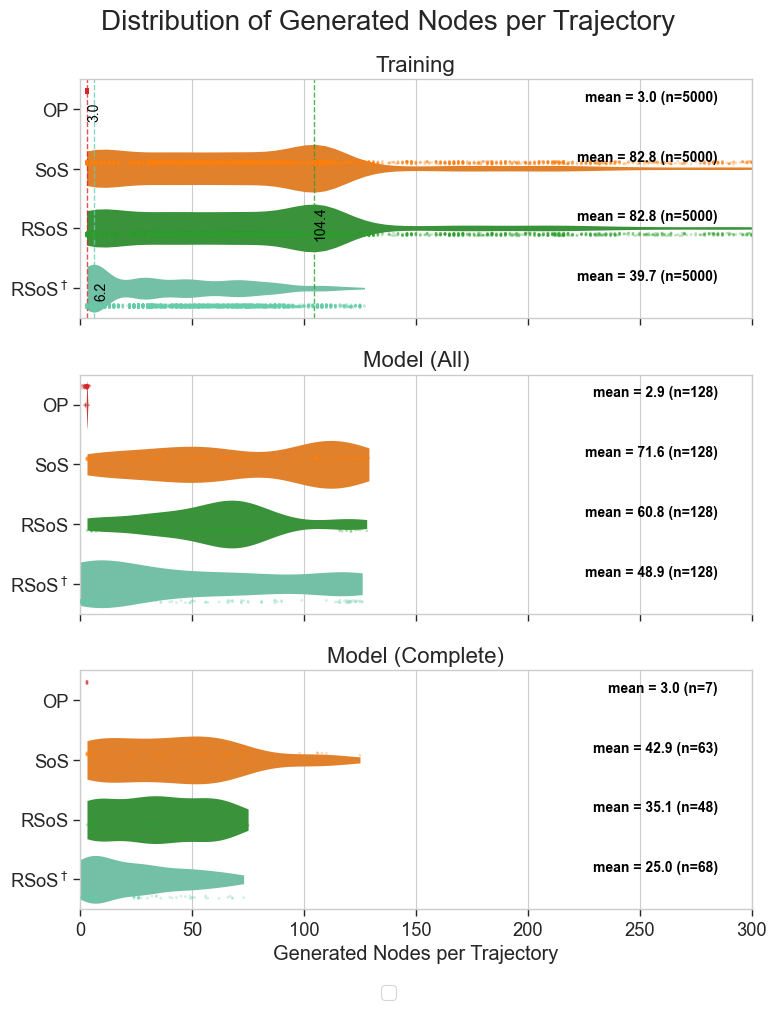

Training Data Statistics:
                 count     mean        std  min   25%   50%    75%    max
method                                                                   
OP              5000.0   3.0000   0.000000  3.0   3.0   3.0    3.0    3.0
RSoS            5000.0  82.8106  69.666737  3.0  31.0  74.0  107.0  443.0
RSoS$^\dagger$  5000.0  39.7496  32.875934  3.0   7.0  32.0   66.0  127.0
SoS             5000.0  82.8106  69.666737  3.0  31.0  74.0  107.0  443.0

Model (All) Statistics:
                count       mean        std  min    25%   50%    75%    max
method                                                                     
OP              128.0   2.882812   0.463147  1.0   3.00   3.0    3.0    4.0
RSoS            128.0  60.796875  30.905841  3.0  38.75  64.5   75.0  128.0
RSoS$^\dagger$  128.0  48.851562  44.984177  0.0   5.00  35.0   87.0  126.0
SoS             128.0  71.625000  41.347386  3.0  36.00  67.0  107.0  129.0

Model (Complete) Statistics:
                cou

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.collections import PolyCollection
from scipy.stats import gaussian_kde

def kde_mode(series):
    """
    Approximate the mode by finding the peak of the kernel density estimate.
    This usually aligns better with the 'thickest' part of a violin than 
    simply using pandas.Series.mode() or a histogram bin.
    """
    data = series.dropna().values
    if len(data) < 2:
        # If there's only one value, return it directly
        return np.mean(data) if len(data) > 0 else np.nan
    
    # Build a Gaussian KDE over a dense grid
    kde = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 500)
    pdf = kde(xs)
    # The mode is where pdf is maximal
    return xs[np.argmax(pdf)]

def create_node_distribution_comparison(train_df, trajectory_df):
    """
    1) Relabel RSoS-Correct -> RSoS$^\\dagger$ 
    2) Plot darker, dashed vertical lines at the kernel-density-based modes 
       of each method from the Training set, and annotate with "Mode = ..."
    3) Annotate the means at the right with "mean = ..." 
    4) Subplot order: Training, Model (All), Model (Complete).
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.5)
    # --------------------------------------------------------------------
    # 1) Rename "RSoS-Correct" to "RSoS$^\dagger$" in all dataframes
    # --------------------------------------------------------------------
    # For simplicity, do this at the very end of data prep:
    def rename_rso_correct(df):
        df = df.copy()
        df.loc[df['method'] == 'RSoS-Correct', 'method'] = r"RSoS$^\dagger$"
        return df

    # Updated color mapping with the dagger label
    method_colors = {
        'OP':               '#d62728',   # red
        'SoS':              '#ff7f0e',   # orange
        'RSoS':             '#2ca02c',   # green
        r'RSoS$^\dagger$':  '#66cdaa'    # slightly different green
    }

    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.5)

    methods_original = ['OP', 'SoS', 'RSoS', 'RSoS-Correct']

    # Prepare model output data
    model_df_all = trajectory_df[trajectory_df['method'].isin(methods_original)].copy()
    model_df_all['source'] = 'Model (All)'

    model_df_valid = trajectory_df[
        (trajectory_df['method'].isin(methods_original)) & 
        (trajectory_df['is_valid'] == True)
    ].copy()
    model_df_valid['source'] = 'Model (Complete)'

    # -------------------------------------------------
    # Prepare training data in a “long” format:
    # -------------------------------------------------
    mixed_train = train_df.iloc[:5000].copy()
    correct_train = train_df[
        train_df['is_correct_sos_react'] == True
    ].sort_values('token_length_sos_react').iloc[:5000].copy()

    train_data = []
    # OP
    for _, row in mixed_train.iterrows():
        if row['num_nodes_optimal'] > 0:
            train_data.append({'method': 'OP', 'num_nodes': row['num_nodes_optimal'], 'source': 'Training'})
    # SoS
    for _, row in mixed_train.iterrows():
        if row['num_nodes_sos'] > 0:
            train_data.append({'method': 'SoS', 'num_nodes': row['num_nodes_sos'], 'source': 'Training'})
    # RSoS
    for _, row in mixed_train.iterrows():
        if row['num_nodes_sos_react'] > 0:
            train_data.append({'method': 'RSoS', 'num_nodes': row['num_nodes_sos_react'], 'source': 'Training'})
    # RSoS-Correct
    for _, row in correct_train.iterrows():
        if row['num_nodes_sos_react'] > 0:
            train_data.append({'method': 'RSoS-Correct',
                               'num_nodes': row['num_nodes_sos_react'],
                               'source': 'Training'})

    train_df_plot = pd.DataFrame(train_data)
    train_df_plot['source'] = 'Training'

    # Rename RSoS-Correct -> RSoS$^\dagger$
    train_df_plot = rename_rso_correct(train_df_plot)
    model_df_all = rename_rso_correct(model_df_all)
    model_df_valid = rename_rso_correct(model_df_valid)

    # Concatenate for plotting
    combined_df = pd.concat([
        train_df_plot[['method','num_nodes','source']],
        model_df_all[['method','num_nodes','source']],
        model_df_valid[['method','num_nodes','source']]
    ])

    # Final list of methods with the dagger label
    methods_to_include = [ 'OP', 'SoS', 'RSoS', r'RSoS$^\dagger$' ]

    # --------------------------------------------------------------------
    # 2) Compute the kernel-density-based mode from Training data
    #    for each method, so we can draw a dashed line & annotation.
    # --------------------------------------------------------------------
    training_modes = {}
    for m in methods_to_include:
        subset = train_df_plot.loc[train_df_plot['method'] == m, 'num_nodes']
        if len(subset) > 0:
            training_modes[m] = kde_mode(subset)
        else:
            training_modes[m] = np.nan

    # --------------------------------------------------------------------
    # 3) Subplot order: Training, Model (All), Model (Complete)
    # --------------------------------------------------------------------
    source_order = ['Training', 'Model (All)', 'Model (Complete)']

    # --------------------------------------------------------------------
    # Create subplots
    # --------------------------------------------------------------------
    fig, axes = plt.subplots(nrows=len(source_order), figsize=(8, 10), sharex=True)
    if len(source_order) == 1:
        axes = [axes]

    for i, src in enumerate(source_order):
        ax = axes[i]
        data_sub = combined_df[combined_df['source'] == src]

        # Main violin + strip
        sns.violinplot(
            ax=ax,
            data=data_sub,
            x='num_nodes',
            y='method',
            order=methods_to_include,
            palette=method_colors,
            cut=0,
            scale='width',
            inner=None,
            linewidth=0
        )
        sns.stripplot(
            ax=ax,
            data=data_sub,
            x='num_nodes',
            y='method',
            order=methods_to_include,
            palette=method_colors,
            alpha=0.3,
            size=2,
            jitter=True,
            dodge=True
        )

        # Dashed vertical line + annotation for each method’s Training-mode
        for m in methods_to_include:
            if src == 'Training' and m!= 'SoS':
                mode_val = training_modes[m]
                if np.isnan(mode_val):
                    continue
                # Draw the line
                ax.axvline(
                    mode_val,
                    linestyle='--',
                    linewidth=1,
                    color=method_colors[m],
                    alpha=0.8
                )
                # Annotate the mode value near the line
                y_center = methods_to_include.index(m)
                ax.text(
                    mode_val,
                    y_center+0.2,  # shift upward so it doesn't overlap the violin
                    f"{mode_val:.1f}",
                    ha='left',
                    va='bottom',
                    color='black',
                    fontsize=10,
                    rotation=90,
                )

        ax.set_xlim(0, 300)
        # Mean annotation at the right side
        for m in methods_to_include:
            data_m = data_sub[data_sub['method'] == m]
            if len(data_m) == 0:
                continue
            mean_val = data_m['num_nodes'].mean()
            count = len(data_m)
            y_center = methods_to_include.index(m)
            xlim = ax.get_xlim()
            # ~95% of x-axis to the right
            text_x = xlim[1] * 0.95
            ax.text(
                text_x,
                y_center-0.2,
                f"mean = {mean_val:.1f} (n={count})",
                ha='right',
                va='center',
                fontsize=10,
                color='black',
                fontweight='bold'
            )

        ax.set_title(src, fontsize=16)
        ax.set_ylabel("")
        ax.set_xlabel("Generated Nodes per Trajectory")
        

    # Single legend
    handles, labels = axes[0].get_legend_handles_labels()
    for ax in axes:
        if ax.get_legend():
            ax.get_legend().remove()

    fig.legend(
        handles[:len(methods_to_include)],
        labels[:len(methods_to_include)],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(methods_to_include),
        frameon=True,
        fancybox=True
    )

    # Tighten layout
    fig.suptitle("Distribution of Generated Nodes per Trajectory", fontsize=20, y=0.95)
    fig.tight_layout(rect=[0,0,1,0.94])
    plt.subplots_adjust(
        top=0.88,    # move the top edge of the subplots up/down
        bottom=0.05  # move the bottom edge of the subplots up/down
    )

    # Save
    filename = "images/node_distribution_comparison_combined.pdf"
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.pdf', '.png'), format='png', dpi=150, bbox_inches='tight')
    plt.show()

    # -- Some logs/stats
    print("Training Data Statistics:")
    print(train_df_plot.groupby('method')['num_nodes'].describe())
    print("\nModel (All) Statistics:")
    print(model_df_all.groupby('method')['num_nodes'].describe())
    print("\nModel (Complete) Statistics:")
    print(model_df_valid.groupby('method')['num_nodes'].describe())


df_1p5B = trajectory_df[trajectory_df["model_size"]=="1.5B"]
create_node_distribution_comparison(train_df, df_1p5B)

/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/3952700558.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/3952700558.py:160: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/3952700558.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/3952700558.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

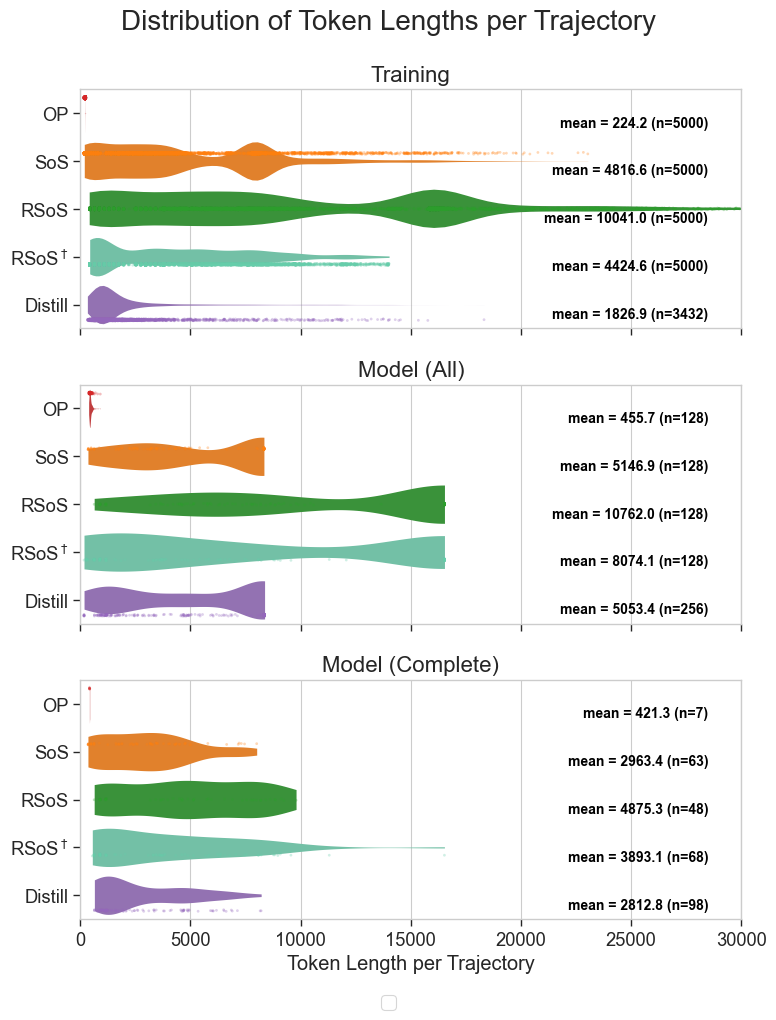

=== Training Stats ===
                 count          mean          std    min     25%     50%  \
method                                                                     
Distill         3432.0   1826.899184  2018.322392  322.0   826.0  1169.0   
OP              5000.0    224.167800     6.606813  172.0   224.0   224.0   
RSoS            5000.0  10041.020200  8186.360849  428.0  3741.0  7903.0   
RSoS$^\dagger$  5000.0   4424.560800  3571.326445  428.0   870.0  3787.0   
SoS             5000.0   4816.606400  3939.503784  182.0  1706.0  3771.0   

                     75%      max  
method                             
Distill          1837.25  18321.0  
OP                224.00    246.0  
RSoS            15994.00  48774.0  
RSoS$^\dagger$   7155.25  14012.0  
SoS              7876.00  23030.0  

=== Model (All) Stats ===
                count          mean          std    min      25%      50%  \
method                                                                      
Distill    

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_token_length_violin_plot(train_df, trajectory_df):
    """
    Create violin plots of token lengths for:
      - Training data: from columns token_length_optimal, token_length_sos, token_length_sos_react, etc.
      - Model data: from trajectory_df's 'token_count'.
    
    Methods included:
      OP, SoS, RSoS, RSoS-Correct (renamed RSoS^dagger), and Distill (model only).
    
    Produces 3 subplots for: Training, Model (All), Model (Complete).
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.5)
    # ------------------------------------------------------------------------
    # 1) Method definitions and color mapping (with Distill added).
    # ------------------------------------------------------------------------
    methods_original = ['OP', 'SoS', 'RSoS', 'RSoS-Correct', 'Distill']
    
    method_colors = {
        'OP':               '#d62728',  # red
        'SoS':              '#ff7f0e',  # orange
        'RSoS':             '#2ca02c',  # green
        r'RSoS$^\dagger$':  '#66cdaa',  # turquoise
        'Distill':          '#9467bd'   # purple
    }

    # Rename RSoS-Correct → RSoS$^\dagger$
    def rename_rso_correct_method(df):
        df = df.copy()
        df.loc[df['method'] == 'RSoS-Correct', 'method'] = r'RSoS$^\dagger$'
        return df

    # ------------------------------------------------------------------------
    # 2) Build "Training" token-length data.
    # ------------------------------------------------------------------------
    mixed_train = train_df.iloc[:5000].copy()
    correct_train = (
        train_df[train_df['is_correct_sos_react'] == True]
        .sort_values('token_length_sos_react')
        .iloc[:5000]
        .copy()
    )
    
    train_data_list = []
    
    # OP → token_length_optimal
    for _, row in mixed_train.iterrows():
        val = row.get('token_length_optimal', 0)
        if val > 0:
            train_data_list.append({
                'method': 'OP',
                'token_length': val,
                'source': 'Training'
            })

    # SoS → token_length_sos
    for _, row in mixed_train.iterrows():
        val = row.get('token_length_sos', 0)
        if val > 0:
            train_data_list.append({
                'method': 'SoS',
                'token_length': val,
                'source': 'Training'
            })

    # RSoS → token_length_sos_react
    for _, row in mixed_train.iterrows():
        val = row.get('token_length_sos_react', 0)
        if val > 0:
            train_data_list.append({
                'method': 'RSoS',
                'token_length': val,
                'source': 'Training'
            })

    # RSoS-Correct → token_length_sos_react, but from correct_train
    for _, row in correct_train.iterrows():
        val = row.get('token_length_sos_react', 0)
        if val > 0:
            train_data_list.append({
                'method': 'RSoS-Correct',
                'token_length': val,
                'source': 'Training'
            })

    # Distill → token_length_deepseek (assuming from your example)
    for _, row in correct_train.iterrows():
        val = row.get('token_length_deepseek', 0)
        if val > 0:
            train_data_list.append({
                'method': 'Distill',
                'token_length': val,
                'source': 'Training'
            })

    train_df_plot = pd.DataFrame(train_data_list)

    # ------------------------------------------------------------------------
    # 3) Build "Model" data from trajectory_df's 'token_count'
    # ------------------------------------------------------------------------
    model_df_all = trajectory_df[
        trajectory_df['method'].isin(methods_original)
    ].copy()
    model_df_all['source'] = 'Model (All)'

    model_df_valid = trajectory_df[
        (trajectory_df['method'].isin(methods_original)) & 
        (trajectory_df['is_valid'] == True)
    ].copy()
    model_df_valid['source'] = 'Model (Complete)'

    # Rename RSoS-Correct → RSoS$^\dagger$ in both model sets
    model_df_all = rename_rso_correct_method(model_df_all)
    model_df_valid = rename_rso_correct_method(model_df_valid)

    # Keep only relevant columns and rename token_count -> token_length
    model_df_all_plot = model_df_all[['method', 'token_count', 'source']].rename(
        columns={'token_count': 'token_length'}
    )
    model_df_valid_plot = model_df_valid[['method', 'token_count', 'source']].rename(
        columns={'token_count': 'token_length'}
    )

    # Also rename in training data
    train_df_plot = rename_rso_correct_method(train_df_plot)

    # ------------------------------------------------------------------------
    # 4) Combine all into one DataFrame
    # ------------------------------------------------------------------------
    combined_df = pd.concat(
        [train_df_plot, model_df_all_plot, model_df_valid_plot],
        ignore_index=True
    )

    # Final method list with RSoS^dagger
    methods_to_include = ['OP', 'SoS', 'RSoS', r'RSoS$^\dagger$', 'Distill']
    source_order = ['Training', 'Model (All)', 'Model (Complete)']

    # ------------------------------------------------------------------------
    # 5) Plot
    # ------------------------------------------------------------------------
    fig, axes = plt.subplots(nrows=len(source_order), figsize=(8, 10), sharex=True)

    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.5)

    if len(source_order) == 1:
        axes = [axes]

    for i, src in enumerate(source_order):
        ax = axes[i]
        subset = combined_df[combined_df['source'] == src]

        # Violin plot
        sns.violinplot(
            ax=ax,
            data=subset,
            x='token_length',
            y='method',
            order=methods_to_include,
            palette=method_colors,
            cut=0,
            scale='width',
            inner=None,
            linewidth=0
        )

        # Strip plot
        sns.stripplot(
            ax=ax,
            data=subset,
            x='token_length',
            y='method',
            order=methods_to_include,
            palette=method_colors,
            alpha=0.3,
            size=2,
            jitter=True,
            dodge=True
        )

        # (A) Set x-limit to [0, 30000]
        ax.set_xlim(0, 30000)

        # (B) Add mean annotations on the right side, shifted up by 0.2
        for m in methods_to_include:
            sub_m = subset[subset['method'] == m]
            if len(sub_m) == 0:
                continue
            mean_val = sub_m['token_length'].mean()
            count = len(sub_m)
            # Find the y-position for the method
            y_center = methods_to_include.index(m)
            # 95% of the right side
            xlim = ax.get_xlim()
            text_x = xlim[1] * 0.95

            ax.text(
                text_x,
                y_center + 0.2,  # shift upward by 0.2
                f"mean = {mean_val:.1f} (n={count})",
                ha='right',
                va='center',
                color='black',
                fontsize=10,
                fontweight='bold'
            )

        ax.set_title(src, fontsize=16)
        ax.set_xlabel("Token Length per Trajectory")
        ax.set_ylabel("")

    # Single legend
    handles, labels = axes[0].get_legend_handles_labels()
    for ax in axes:
        if ax.get_legend():
            ax.get_legend().remove()

    fig.legend(
        handles[:len(methods_to_include)],
        labels[:len(methods_to_include)],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(methods_to_include),
        frameon=True,
        fancybox=True
    )

    # Title & layout
    fig.suptitle("Distribution of Token Lengths per Trajectory", fontsize=20, y=0.96)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(
        top=0.88,    # move the top edge of the subplots up/down
        bottom=0.05  # move the bottom edge of the subplots up/down
    )

    # Save the figure
    filename = "images/token_length_violin_plot.pdf"
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.pdf', '.png'), format='png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print some descriptive stats
    print("=== Training Stats ===")
    print(train_df_plot.groupby('method')['token_length'].describe())

    print("\n=== Model (All) Stats ===")
    print(model_df_all_plot.groupby('method')['token_length'].describe())

    print("\n=== Model (Complete) Stats ===")
    print(model_df_valid_plot.groupby('method')['token_length'].describe())


# Example usage:
df_1p5B = trajectory_df[trajectory_df["model_size"]=="1.5B"]
create_token_length_violin_plot(train_df, df_1p5B)


/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/1749111560.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/1749111560.py:142: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/1749111560.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/1749111560.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

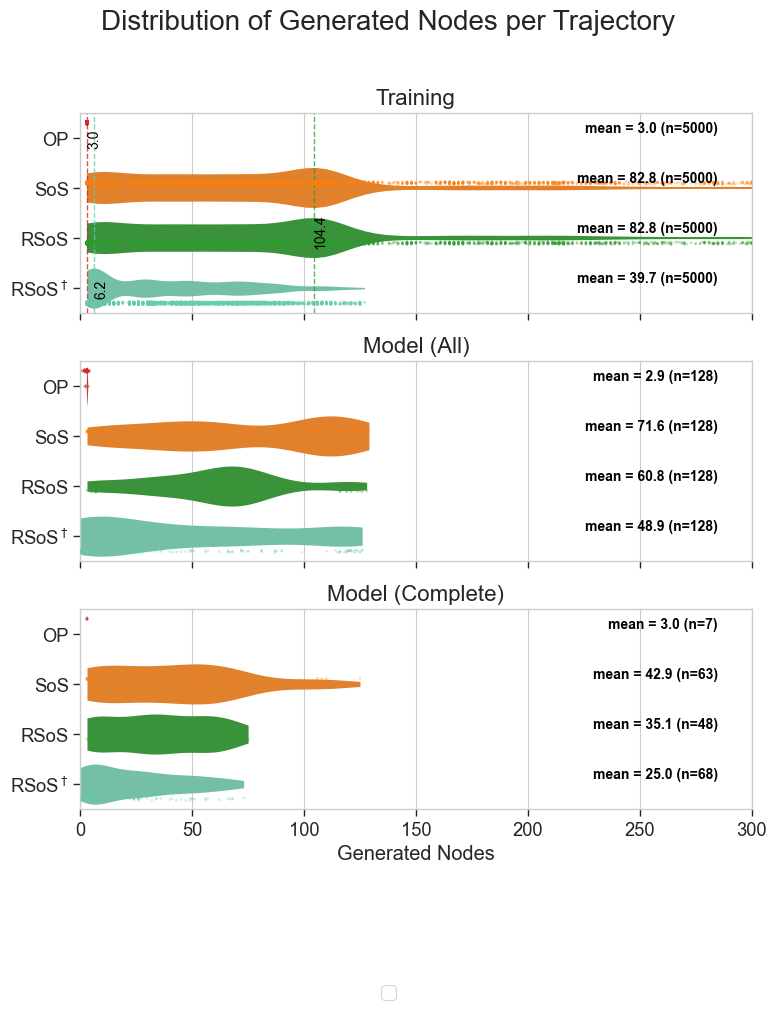

Training Data Statistics:
                 count     mean        std  min   25%   50%    75%    max
method                                                                   
OP              5000.0   3.0000   0.000000  3.0   3.0   3.0    3.0    3.0
RSoS            5000.0  82.8106  69.666737  3.0  31.0  74.0  107.0  443.0
RSoS$^\dagger$  5000.0  39.7496  32.875934  3.0   7.0  32.0   66.0  127.0
SoS             5000.0  82.8106  69.666737  3.0  31.0  74.0  107.0  443.0

Model (All) Statistics:
                count       mean        std  min    25%   50%    75%    max
method                                                                     
OP              128.0   2.882812   0.463147  1.0   3.00   3.0    3.0    4.0
RSoS            128.0  60.796875  30.905841  3.0  38.75  64.5   75.0  128.0
RSoS$^\dagger$  128.0  48.851562  44.984177  0.0   5.00  35.0   87.0  126.0
SoS             128.0  71.625000  41.347386  3.0  36.00  67.0  107.0  129.0

Model (Complete) Statistics:
                cou

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.collections import PolyCollection
from scipy.stats import gaussian_kde

def kde_mode(series):
    """
    Approximate the mode by finding the peak of the kernel density estimate.
    This usually aligns better with the 'thickest' part of a violin than 
    simply using pandas.Series.mode() or a histogram bin.
    """
    data = series.dropna().values
    if len(data) < 2:
        # If there's only one value, return it directly
        return np.mean(data) if len(data) > 0 else np.nan
    
    # Build a Gaussian KDE over a dense grid
    kde = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 500)
    pdf = kde(xs)
    # The mode is where pdf is maximal
    return xs[np.argmax(pdf)]

def create_node_distribution_comparison(train_df, trajectory_df):
    """
    1) Relabel RSoS-Correct -> RSoS$^\\dagger$ 
    2) Plot darker, dashed vertical lines at the kernel-density-based modes 
       of each method from the Training set, and annotate with "Mode = ..."
    3) Annotate the means at the right with "mean = ..." 
    4) Subplot order: Training, Model (All), Model (Complete).
    """

    # --------------------------------------------------------------------
    # 1) Rename "RSoS-Correct" to "RSoS$^\dagger$" in all dataframes
    # --------------------------------------------------------------------
    # For simplicity, do this at the very end of data prep:
    def rename_rso_correct(df):
        df = df.copy()
        df.loc[df['method'] == 'RSoS-Correct', 'method'] = r"RSoS$^\dagger$"
        return df

    # Updated color mapping with the dagger label
    method_colors = {
        'OP':               '#d62728',   # red
        'SoS':              '#ff7f0e',   # orange
        'RSoS':             '#2ca02c',   # green
        r'RSoS$^\dagger$':  '#66cdaa'    # slightly different green
    }

    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.5)

    methods_original = ['OP', 'SoS', 'RSoS', 'RSoS-Correct']

    # Prepare model output data
    model_df_all = trajectory_df[trajectory_df['method'].isin(methods_original)].copy()
    model_df_all['source'] = 'Model (All)'

    model_df_valid = trajectory_df[
        (trajectory_df['method'].isin(methods_original)) & 
        (trajectory_df['is_valid'] == True)
    ].copy()
    model_df_valid['source'] = 'Model (Complete)'

    # -------------------------------------------------
    # Prepare training data in a “long” format:
    # -------------------------------------------------
    mixed_train = train_df.iloc[:5000].copy()
    correct_train = train_df[
        train_df['is_correct_sos_react'] == True
    ].sort_values('token_length_sos_react').iloc[:5000].copy()

    train_data = []
    # OP
    for _, row in mixed_train.iterrows():
        if row['num_nodes_optimal'] > 0:
            train_data.append({'method': 'OP', 'num_nodes': row['num_nodes_optimal'], 'source': 'Training'})
    # SoS
    for _, row in mixed_train.iterrows():
        if row['num_nodes_sos'] > 0:
            train_data.append({'method': 'SoS', 'num_nodes': row['num_nodes_sos'], 'source': 'Training'})
    # RSoS
    for _, row in mixed_train.iterrows():
        if row['num_nodes_sos_react'] > 0:
            train_data.append({'method': 'RSoS', 'num_nodes': row['num_nodes_sos_react'], 'source': 'Training'})
    # RSoS-Correct
    for _, row in correct_train.iterrows():
        if row['num_nodes_sos_react'] > 0:
            train_data.append({'method': 'RSoS-Correct',
                               'num_nodes': row['num_nodes_sos_react'],
                               'source': 'Training'})

    train_df_plot = pd.DataFrame(train_data)
    train_df_plot['source'] = 'Training'

    # Rename RSoS-Correct -> RSoS$^\dagger$
    train_df_plot = rename_rso_correct(train_df_plot)
    model_df_all = rename_rso_correct(model_df_all)
    model_df_valid = rename_rso_correct(model_df_valid)

    # Concatenate for plotting
    combined_df = pd.concat([
        train_df_plot[['method','num_nodes','source']],
        model_df_all[['method','num_nodes','source']],
        model_df_valid[['method','num_nodes','source']]
    ])

    # Final list of methods with the dagger label
    methods_to_include = [ 'OP', 'SoS', 'RSoS', r'RSoS$^\dagger$' ]

    # --------------------------------------------------------------------
    # 2) Compute the kernel-density-based mode from Training data
    #    for each method, so we can draw a dashed line & annotation.
    # --------------------------------------------------------------------
    training_modes = {}
    for m in methods_to_include:
        subset = train_df_plot.loc[train_df_plot['method'] == m, 'num_nodes']
        if len(subset) > 0:
            training_modes[m] = kde_mode(subset)
        else:
            training_modes[m] = np.nan

    # --------------------------------------------------------------------
    # 3) Subplot order: Training, Model (All), Model (Complete)
    # --------------------------------------------------------------------
    source_order = ['Training', 'Model (All)', 'Model (Complete)']

    # --------------------------------------------------------------------
    # Create subplots
    # --------------------------------------------------------------------
    fig, axes = plt.subplots(nrows=len(source_order), figsize=(8, 10), sharex=True)
    if len(source_order) == 1:
        axes = [axes]

    for i, src in enumerate(source_order):
        ax = axes[i]
        data_sub = combined_df[combined_df['source'] == src]

        # Main violin + strip
        sns.violinplot(
            ax=ax,
            data=data_sub,
            x='num_nodes',
            y='method',
            order=methods_to_include,
            palette=method_colors,
            cut=0,
            scale='width',
            inner=None,
            linewidth=0
        )
        sns.stripplot(
            ax=ax,
            data=data_sub,
            x='num_nodes',
            y='method',
            order=methods_to_include,
            palette=method_colors,
            alpha=0.3,
            size=2,
            jitter=True,
            dodge=True
        )

        # Dashed vertical line + annotation for each method’s Training-mode
        for m in methods_to_include:
            if src == 'Training' and m!= 'SoS':
                mode_val = training_modes[m]
                if np.isnan(mode_val):
                    continue
                # Draw the line
                ax.axvline(
                    mode_val,
                    linestyle='--',
                    linewidth=1,
                    color=method_colors[m],
                    alpha=0.8
                )
                # Annotate the mode value near the line
                y_center = methods_to_include.index(m)
                ax.text(
                    mode_val,
                    y_center+0.2,  # shift upward so it doesn't overlap the violin
                    f"{mode_val:.1f}",
                    ha='left',
                    va='bottom',
                    color='black',
                    fontsize=10,
                    rotation=90,
                )

        ax.set_xlim(0, 300)
        # Mean annotation at the right side
        for m in methods_to_include:
            data_m = data_sub[data_sub['method'] == m]
            if len(data_m) == 0:
                continue
            mean_val = data_m['num_nodes'].mean()
            count = len(data_m)
            y_center = methods_to_include.index(m)
            xlim = ax.get_xlim()
            # ~95% of x-axis to the right
            text_x = xlim[1] * 0.95
            ax.text(
                text_x,
                y_center-0.2,
                f"mean = {mean_val:.1f} (n={count})",
                ha='right',
                va='center',
                fontsize=10,
                color='black',
                fontweight='bold'
            )

        ax.set_title(src, fontsize=16)
        ax.set_ylabel("")
        ax.set_xlabel("Generated Nodes")
        

    # Single legend
    handles, labels = axes[0].get_legend_handles_labels()
    for ax in axes:
        if ax.get_legend():
            ax.get_legend().remove()

    fig.legend(
        handles[:len(methods_to_include)],
        labels[:len(methods_to_include)],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(methods_to_include),
        frameon=True,
        fancybox=True
    )

    # Tighten layout
    fig.suptitle("Distribution of Generated Nodes per Trajectory", fontsize=20, y=0.95)
    fig.tight_layout(rect=[0,0,1,0.94])
    plt.subplots_adjust(bottom=0.15)

    # Save
    filename = "images/node_distribution_comparison_combined.pdf"
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.pdf', '.png'), format='png', dpi=150, bbox_inches='tight')
    plt.show()

    # -- Some logs/stats
    print("Training Data Statistics:")
    print(train_df_plot.groupby('method')['num_nodes'].describe())
    print("\nModel (All) Statistics:")
    print(model_df_all.groupby('method')['num_nodes'].describe())
    print("\nModel (Complete) Statistics:")
    print(model_df_valid.groupby('method')['num_nodes'].describe())


df_1p5B = trajectory_df[trajectory_df["model_size"]=="1.5B"]
create_node_distribution_comparison(train_df, df_1p5B)

In [10]:
def print_trajectories_by_failure_type_from_df(trajectories_df, file_path=None, failure_type=None, model_size=None, dataset_type=None, dataset_size=None, context_length=None, limit=5):
    """
    Print trajectories that match specified criteria using the pre-processed DataFrame.
    
    Args:
        trajectories_df (pd.DataFrame): DataFrame containing processed trajectories
        file_path (str, optional): Path to specific file to filter by
        failure_type (str, optional): Type of failure to filter by
        model_size (str, optional): Model size to filter by (e.g., "0.5B")
        dataset_type (str, optional): Dataset type to filter by (e.g., "search")
        limit (int, optional): Maximum number of trajectories to print
    """
    # Start with the full DataFrame
    filtered_df = trajectories_df.copy()
    
    # Apply filters
    if file_path:
        filtered_df = filtered_df[filtered_df["file_path"] == file_path]
    
    if model_size:
        filtered_df = filtered_df[filtered_df["model_size"] == model_size]
        
    if dataset_type:
        filtered_df = filtered_df[filtered_df["dataset_type"] == dataset_type]
        
    if dataset_size:
        filtered_df = filtered_df[filtered_df["dataset_size"] == dataset_size]
    
    if failure_type:
        if failure_type == "arithmetic_error":
            filtered_df = filtered_df[filtered_df["arithmetic_error"]]
        elif failure_type == "invalid_number":
            filtered_df = filtered_df[filtered_df["invalid_number_usage"]]
        elif failure_type == "mismatched_target":
            filtered_df = filtered_df[filtered_df["mismatched_target"]]
        elif failure_type == "incomplete":
            # Get max token count for each file
            file_max_tokens = filtered_df.groupby("file_path")["token_count"].max().to_dict()
            # Filter trajectories that hit max tokens and have formatting issues
            filtered_df = filtered_df[
                filtered_df.apply(
                    lambda row: row["formatting_issues"] and np.isclose(row["token_count"],file_max_tokens[row["file_path"]],rtol=1e-2), 
                    axis=1
                )
            ]
        elif failure_type == "formatting_issues":
            file_max_tokens = filtered_df.groupby("file_path")["token_count"].max().to_dict()
            filtered_df = filtered_df[
                filtered_df.apply(
                    lambda row: row["formatting_issues"] and (np.isclose(row["token_count"],file_max_tokens[row["file_path"]],rtol=1e-2) == False), 
                    axis=1
                )
            ]
        elif failure_type == "valid":
            filtered_df = filtered_df[filtered_df["is_valid"]]
        else:
            print(f"Unknown failure type: {failure_type}")
            return
    
    # Print results
    print(f"Found {len(filtered_df)} trajectories matching criteria")
    
    for i, (_, traj) in enumerate(filtered_df.head(limit).iterrows()):
        print(f"\n--- Trajectory {traj['trajectory_index']} ---")
        print(f"Model: {traj['model_size']} {traj['dataset_type']} {traj['context_length']} {traj['dataset_size']}")
        print(f"Problem: {traj['nums']}")
        print(f"Target: {traj['target']}")
        print(f"Token count: {traj['token_count']}")
        
        if traj.get("arithmetic_error"):
            print(f"Arithmetic errors: {traj['arithmetic_error_count']} out of {traj['total_equations']} equations")
            print(f"Sign errors: {traj.get('sign_errors', 0)} out of {traj['arithmetic_error_count']} arithmetic errors")
        
        if traj.get("heuristic_calculation_count", 0) > 0:
            print(f"Heuristic calculations: {traj['heuristic_calculation_count']}")
            print(f"Heuristic calculation errors: {traj.get('heuristic_arithmetic_errors', 0)}")
        
        if traj.get("node_recall_errors", 0) > 0:
            print(f"Node recall errors: {traj['node_recall_errors']}")
        
        print("\nCompletion:")
        # preamble_pattern = r"system\nYou are Qwen.*?RESULT: final_value\n```\n\nsystem\n"
        # cleaned_completion = re.sub(preamble_pattern, "", traj['completion'], flags=re.DOTALL).strip()
        cleaned_completion = traj['completion']
        print(cleaned_completion)
    
    if len(filtered_df) > limit:
        print(f"\n... {len(filtered_df) - limit} more trajectories not shown")

# Example usage:
# trajectory_df, stats_df = process_json_files("path/to/experiments")
# print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="arithmetic_error", model_size="0.5B")

In [14]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="formatting_issues", model_size="1.5B", dataset_size="5k", dataset_type="deepseek", limit=10)

Found 63 trajectories matching criteria

--- Trajectory 3 ---
Model: 1.5B deepseek 8k 5k
Problem: [10, 30, 42, 5]
Target: 67
Token count: 897

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [10, 30, 42, 5] using only arithmetic operations (+, -, *, /) to reach the target value 67. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```


system
SOLUTION: NO  
OPERATIONS: []  
RESULT: None  

Explanation: The given numbers are 10, 30, 42, and 5. Let's see if any combination can lead to 67. 

First, let me try possible combinations:

If I add all four numbers first: 10 + 30 + 42 + 5 = 87. That's over 67. So maybe subtract something.

Alternatively, 10 * (something)

In [15]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="incomplete", model_size="1.5B", dataset_type="search", dataset_size="5k", limit=1)

Found 50 trajectories matching criteria

--- Trajectory 0 ---
Model: 1.5B search 8k 5k
Problem: [53, 57, 13, 48]
Target: 64
Token count: 8333

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [53, 57, 13, 48] using only arithmetic operations (+, -, *, /) to reach the target value 64. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```

assistant
Current State: 64:[53, 57, 13, 48], Operations: []
Exploring Operation: 57-13=44, Resulting Numbers: [53, 48, 44]
Generated Node #0,0: 64:[53, 48, 44] Operation: 57-13=44
Exploring Operation: 53+48=101, Resulting Numbers: [13, 49, 101]
Generated Node #0,1: 64:[13, 49, 101] Operation: 53+48=101
Exploring Operation: 53+13

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datasets import load_dataset
from tqdm import tqdm

# Set style for scientific publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# Define function to extract node counts
def count_nodes(text):
    """Count the number of nodes in a trajectory"""
    if not isinstance(text, str):
        return 0
    
    # Use your existing get_nodes function and count results
    result = get_nodes(text)
    return len(result['nodes'])

# Function to determine search type (BFS/DFS) from text
def determine_search_type(text):
    """Determine if a trajectory uses BFS or DFS"""
    if not isinstance(text, str):
        return "unknown"
    
    if "(DFS)" in text or "Depth-First Search" in text:
        return "DFS"
    elif "(BFS)" in text or "Breadth-First Search" in text:
        return "BFS"
    else:
        # Try to infer from other text cues
        if "depth" in text.lower() and "first" in text.lower():
            return "DFS"
        elif "breadth" in text.lower() and "first" in text.lower():
            return "BFS"
        return "unknown"

# 1. Process training dataset
print("Loading HuggingFace dataset...")
hf_dataset = load_dataset("MelinaLaimon/stream-of-search-correctness-token-length", split="train")

# Convert to pandas for easier manipulation
print("Converting to pandas DataFrame...")
train_df = pd.DataFrame(hf_dataset)

# Extract node counts for SoS-React
print("Extracting node counts from training data...")
train_df['num_nodes_sos_react'] = [
    count_nodes(row['messages_sos_react'][1]['content']) 
    if isinstance(row['messages_sos_react'], list) and len(row['messages_sos_react']) > 0 
    else 0 
    for row in tqdm(train_df.to_dict('records'))
]

# Extract search type for SoS-React
print("Determining search types...")
train_df['search_type_parsed'] = [
    determine_search_type(row['messages_sos_react'][1]['content'])
    if isinstance(row['messages_sos_react'], list) and len(row['messages_sos_react']) > 0 
    else "unknown"
    for row in tqdm(train_df.to_dict('records'))
]

# 2. Create subsets for the training data
# Mixed trajectories (first 5k)
print("Creating training data subsets...")
mixed_train = train_df.iloc[:5000].copy()
mixed_train_bfs = mixed_train[mixed_train['search_type'] == 'bfs_5']
mixed_train_dfs = mixed_train[mixed_train['search_type'] == 'dfs']

# Correct trajectories (filtered)
correct_train = train_df[train_df['is_correct_sos_react'] == True].sort_values('token_length_sos_react').iloc[:5000].copy()
correct_train_bfs = correct_train[correct_train['search_type'] == 'bfs_5']
correct_train_dfs = correct_train[correct_train['search_type'] == 'dfs']

# 3. Process model output data
print("Processing model output data...")
# Extract node counts and search types for RSoS and RSoS-Correct
rsos_df = df_1p5B[df_1p5B["method"] == "RSoS"].copy()
rsos_correct_df = df_1p5B[df_1p5B["method"] == "RSoS-Correct"].copy()

# Add search type and count nodes
rsos_df['search_type_parsed'] = rsos_df['completion'].apply(determine_search_type)
rsos_correct_df['search_type_parsed'] = rsos_correct_df['completion'].apply(determine_search_type)

# Handle unknown search types (optional)
rsos_df.loc[rsos_df['search_type_parsed'] == 'unknown', 'search_type_parsed'] = 'BFS'  # Default assumption
rsos_correct_df.loc[rsos_correct_df['search_type_parsed'] == 'unknown', 'search_type_parsed'] = 'BFS'  # Default assumption



Loading HuggingFace dataset...
Converting to pandas DataFrame...
Extracting node counts from training data...


100%|██████████| 10000/10000 [00:02<00:00, 4675.52it/s]


Determining search types...


100%|██████████| 10000/10000 [00:00<00:00, 75729.01it/s]


Creating training data subsets...
Processing model output data...


<>:90: SyntaxWarning: invalid escape sequence '\d'
<>:90: SyntaxWarning: invalid escape sequence '\d'
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/4158347296.py:90: SyntaxWarning: invalid escape sequence '\d'
  """
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/4158347296.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/4158347296.py:21: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/4158347296.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

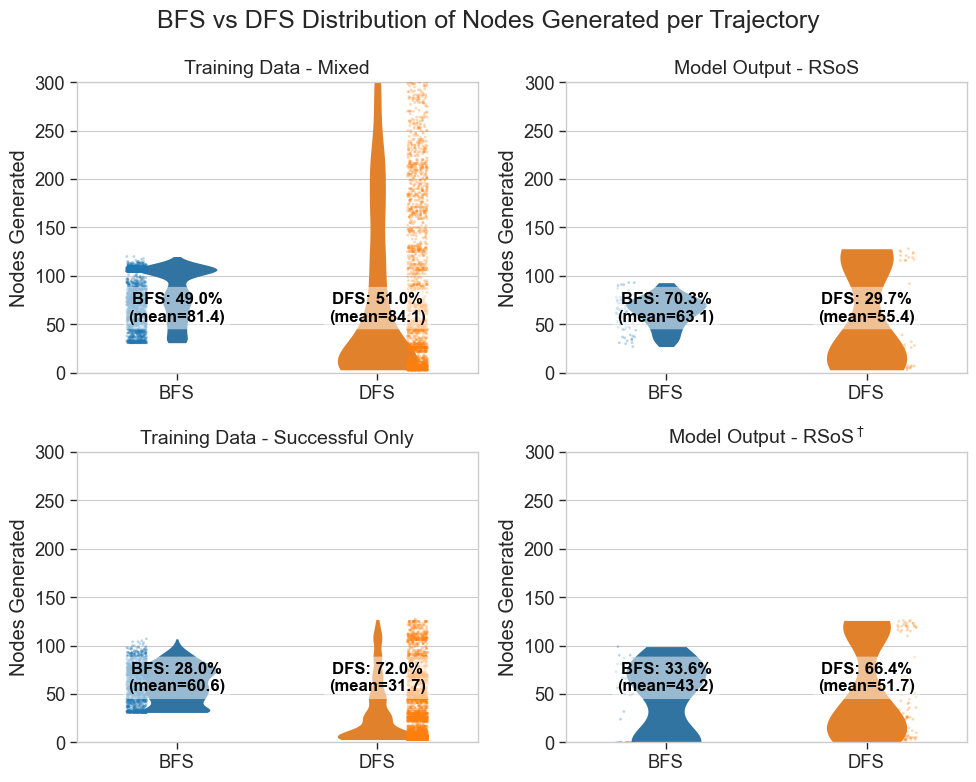

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_violin_search_type(ax, data, title, x='search_type', y='num_nodes'):
    """
    Plots BFS vs DFS data in a single subplot with violin + strip.
    Then annotates each violin with:
      - the proportion of the total (in %),
      - the mean for that category.
    """
    # Increase font scale for better visibility
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.5)

    # We will assume you have only two categories: BFS and DFS.
    categories = ['BFS','DFS']

    # 1) Violin Plot (width=0.4 to make the violins narrower/closer)
    sns.violinplot(
        ax=ax,
        data=data,
        x=x,
        y=y,
        order=categories,                   # BFS=left, DFS=right
        palette=['#1f77b4', '#ff7f0e'],     # BFS=blue, DFS=orange
        cut=0,
        scale='width',
        inner=None,
        linewidth=0,
        width=0.4                           # narrower violins → closer together
    )

    # 2) Strip Plot
    sns.stripplot(
        ax=ax,
        data=data,
        x=x,
        y=y,
        order=categories,
        palette=['#1f77b4', '#ff7f0e'],
        alpha=0.3,
        size=2,
        jitter=True,
        dodge=True
    )

    # Title and axes
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("")               # BFS/DFS is self-explanatory
    ax.set_ylabel("Nodes Generated")
    ax.set_ylim(0, 300)             # Fix y-limits to [0..300]

    # Remove Seaborn’s auto legend
    if ax.get_legend():
        ax.get_legend().remove()

    # 3) Compute counts, means, proportions for BFS/DFS
    total = len(data)
    for i, cat in enumerate(categories):
        cat_data = data.loc[data[x] == cat, y]
        cat_count = len(cat_data)
        cat_mean  = cat_data.mean() if cat_count else 0
        cat_prop  = (cat_count / total * 100) if total > 0 else 0

        # 4) Pick a y-position for the text (e.g. 50 or 95th percentile)
        #    Here, we'll place the box around halfway up the BFS distribution.
        #    If you'd rather near the top, use cat_data.quantile(0.95).
        y_pos = 50  # or cat_data.quantile(0.5), cat_data.quantile(0.95), etc.

        # 5) Add annotation with proportion & mean, plus a semi‐transparent bbox
        ax.text(
            x=i,  # BFS=0, DFS=1
            y=y_pos,
            s=f"{cat}: {cat_prop:.1f}%\n(mean={cat_mean:.1f})",
            ha='center',
            va='bottom',
            color='black',
            fontsize=12,  # Larger text
            fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none',
                      boxstyle='round,pad=0.3')
        )

def create_2x2_violin_plots(
    mixed_train_plot, rsos_plot,
    correct_train_plot, rsos_correct_plot
):
    """
    Creates a 2x2 grid of violin plots:
      Top-left: BFS/DFS for 'mixed_train_plot'
      Top-right: BFS/DFS for 'rsos_plot' (renamed to RSoS^\dagger in the title)
      Bottom-left: BFS/DFS for 'correct_train_plot'
      Bottom-right: BFS/DFS for 'rsos_correct_plot'
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey=False)

    # Top-left: Mixed Train
    plot_violin_search_type(
        ax=axes[0, 0],
        data=mixed_train_plot,
        title="Training Data - Mixed",
        y='num_nodes'
    )

    # Top-right: Model Output - RSoS^\dagger
    plot_violin_search_type(
        ax=axes[0, 1],
        data=rsos_plot,
        title=r"Model Output - RSoS",
        y='num_nodes'
    )

    # Bottom-left: Correct Train
    plot_violin_search_type(
        ax=axes[1, 0],
        data=correct_train_plot,
        title="Training Data - Successful Only",
        y='num_nodes'
    )

    # Bottom-right: Model Output - RSoS-Correct
    plot_violin_search_type(
        ax=axes[1, 1],
        data=rsos_correct_plot,
        title=r"Model Output - RSoS$^\dagger$",
        y='num_nodes'
    )

    # Make a bigger main title
    plt.suptitle("BFS vs DFS Distribution of Nodes Generated per Trajectory",
                 fontsize=18, y=0.98)
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# EXAMPLE OF HOW YOU MIGHT CALL THIS
# ---------------------------------------------------------------------
# Suppose you have:
#   mixed_train_bfs, mixed_train_dfs
#   rsos_df
#   correct_train_bfs, correct_train_dfs
#   rsos_correct_df
#
# Then build DataFrames for each subplot:

mixed_train_plot = pd.DataFrame({
    'num_nodes': mixed_train_bfs['num_nodes_sos_react'].tolist()
                + mixed_train_dfs['num_nodes_sos_react'].tolist(),
    'search_type': ['BFS'] * len(mixed_train_bfs)
                   + ['DFS'] * len(mixed_train_dfs),
    'source': ['Train'] * (len(mixed_train_bfs) + len(mixed_train_dfs))
})

rsos_plot = pd.DataFrame({
    'num_nodes': rsos_df['num_nodes'].tolist(),
    'search_type': rsos_df['search_type_parsed'].tolist(),
    'source': ['Model'] * len(rsos_df),
    'is_valid': rsos_df['is_valid'].tolist()
})

correct_train_plot = pd.DataFrame({
    'num_nodes': correct_train_bfs['num_nodes_sos_react'].tolist()
                 + correct_train_dfs['num_nodes_sos_react'].tolist(),
    'search_type': ['BFS'] * len(correct_train_bfs)
                   + ['DFS'] * len(correct_train_dfs),
    'source': ['Train'] * (len(correct_train_bfs) + len(correct_train_dfs))
})

rsos_correct_plot = pd.DataFrame({
    'num_nodes': rsos_correct_df['num_nodes'].tolist(),
    'search_type': rsos_correct_df['search_type_parsed'].tolist(),
    'source': ['Model'] * len(rsos_correct_df),
    'is_valid': rsos_correct_df['is_valid'].tolist()
})

create_2x2_violin_plots(
    mixed_train_plot, rsos_plot,
    correct_train_plot, rsos_correct_plot
)


Creating visualization...


/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/3239166757.py:60: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/3239166757.py:60: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/3239166757.py:60: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_26186/3239166757.py:60: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Visualization complete!


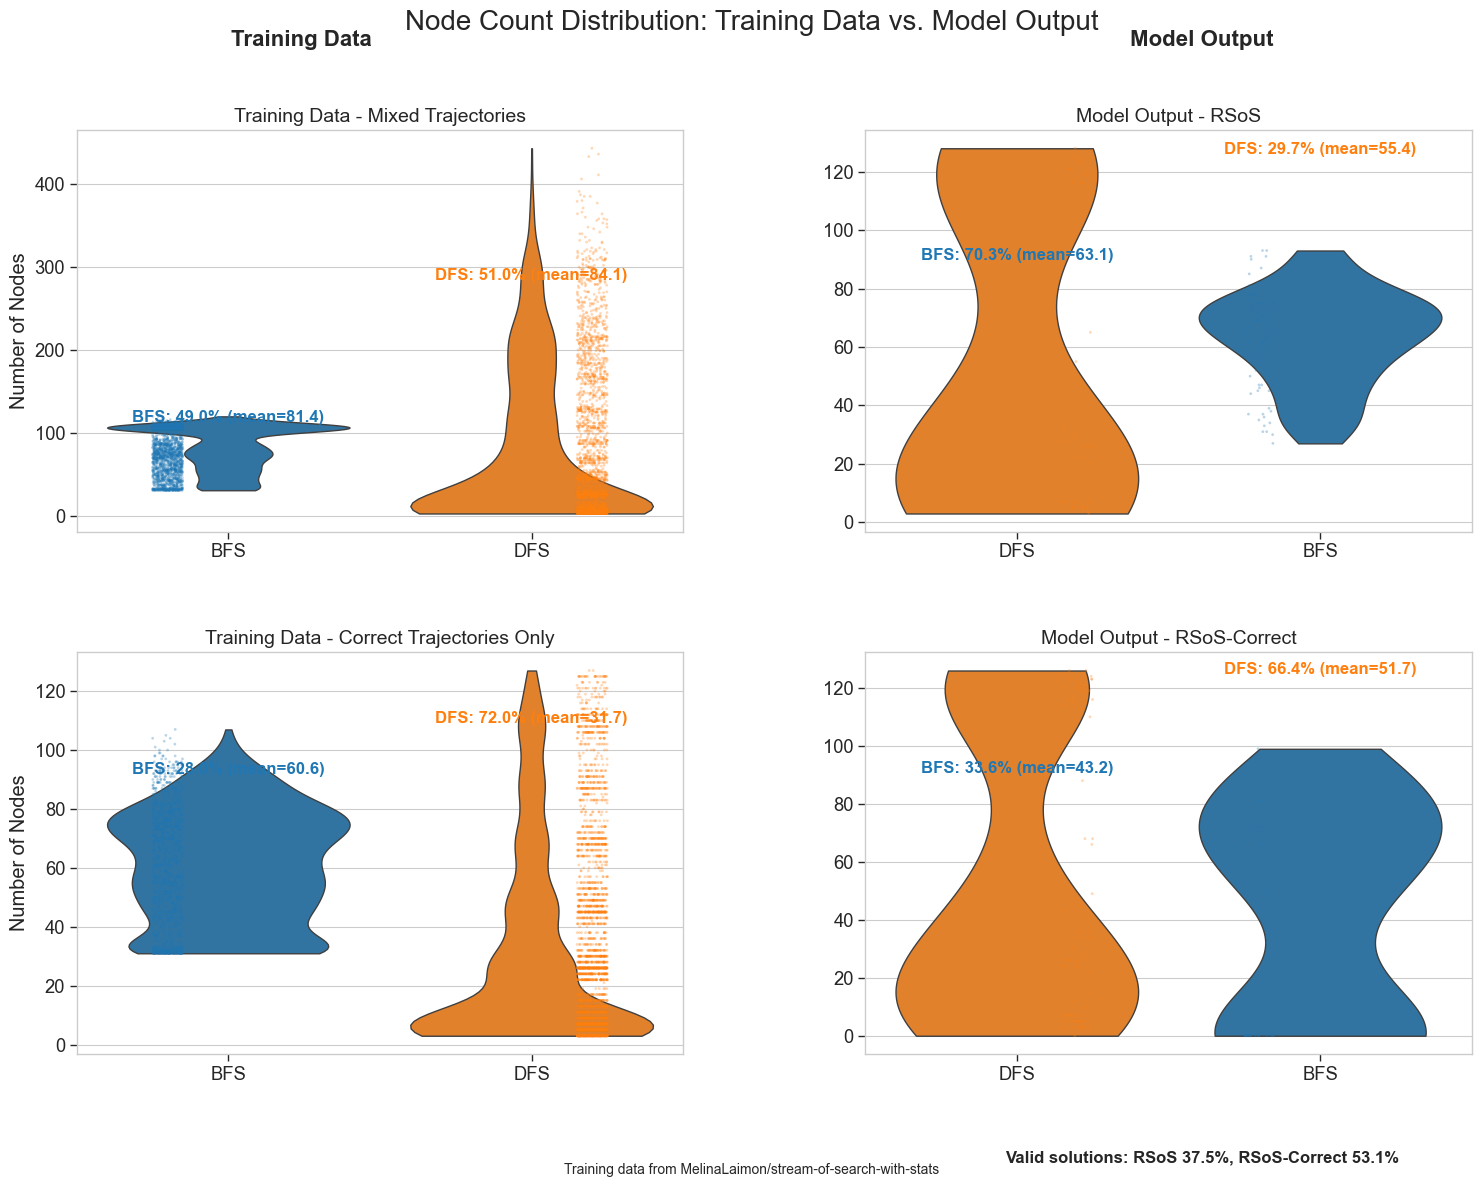

In [45]:
# Set style for scientific publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# 4. Create the visualization
print("Creating visualization...")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Define colors
colors = {
    'BFS_train': '#1f77b4',  # blue
    'DFS_train': '#ff7f0e',  # orange
    'BFS_model': '#1f77b4',  # blue
    'DFS_model': '#ff7f0e',  # orange
}

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_violin(ax, data, x, y, hue, title,
                  left_label=True,
                  is_model=False,
                  hue_order=("BFS","DFS")):
    """
    Plots a horizontal pair of violin plots (BFS vs DFS).
    Then annotates each with:
      - 'BFS: 49.0% (mean=123.4)'
      - 'DFS: 51.0% (mean=456.7)'
    near the top of each violin.
    
    Parameters
    ----------
    ax : matplotlib axes
        The axes on which to draw the plot.
    data : DataFrame
        Must have columns [x, y, hue].
    x : str
        Column name for the categorical variable on the x-axis (e.g. 'search_type').
    y : str
        Column name for the numeric variable (e.g. 'num_nodes').
    hue : str
        Column name that also indicates BFS vs DFS (often the same as x).
    title : str
        Title for this subplot.
    left_label : bool
        If False, remove the y‐axis label.
    is_model : bool
        (Optional) Could be used to pick different colors or styling for model data.
    hue_order : tuple
        Ensures BFS is left and DFS is right in the violin plot.
    """

    # Example palette: BFS=blue, DFS=orange (feel free to change)
    palette = {"BFS": "#1f77b4", "DFS": "#ff7f0e"}

    # 1) Plot the violin with BFS on the left, DFS on the right
    sns.violinplot(
        ax=ax,
        data=data,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        palette=palette,
        cut=0,          # do not extend beyond min/max
        scale="width",  # same violin width
        inner=None      # no internal box/lines
    )

    # 2) Strip plot to show individual points (optional)
    sns.stripplot(
        ax=ax,
        data=data,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        palette=palette,
        alpha=0.3,
        size=2,
        jitter=True,
        dodge=True
    )

    # Remove the auto legend that Seaborn adds
    if ax.get_legend():
        ax.get_legend().remove()

    # 3) Compute BFS/DFS proportions
    counts = data[hue].value_counts()
    total  = sum(counts.get(cat, 0) for cat in hue_order)
    proportions = {}
    for cat in hue_order:
        cat_count = counts.get(cat, 0)
        if total > 0:
            prop = (cat_count / total)*100
        else:
            prop = 0
        proportions[cat] = prop

    # 4) Compute BFS/DFS means
    means = {}
    for cat in hue_order:
        cat_data = data.loc[data[hue] == cat, y]
        means[cat] = cat_data.mean() if len(cat_data) else 0

    # 5) Find a reasonable "top" of each violin to place text
    #    A common approach is to use something like the 95th percentile
    #    so the text is near the top but not off the chart.
    top_y = {}
    for cat in hue_order:
        cat_data = data.loc[data[hue] == cat, y]
        if len(cat_data) > 0:
            top_y[cat] = cat_data.quantile(0.95)
        else:
            top_y[cat] = 0

    # 6) Annotate BFS (x=0) and DFS (x=1).
    #    By default, BFS is x=0, DFS is x=1, if x='search_type' has 2 categories in hue_order.
    #    If you have more than these 2 categories in the data, you may need a safer approach 
    #    (like looking up the actual x-coordinates from Seaborn).
    # BFS
    ax.text(
        x=0,
        y=top_y.get("BFS", 0),
        s=f"BFS: {proportions['BFS']:.1f}% (mean={means['BFS']:.1f})",
        ha='center',
        va='bottom',
        color=palette["BFS"],
        fontsize=12,
        fontweight='bold'
    )
    # DFS
    ax.text(
        x=1,
        y=top_y.get("DFS", 0),
        s=f"DFS: {proportions['DFS']:.1f}% (mean={means['DFS']:.1f})",
        ha='center',
        va='bottom',
        color=palette["DFS"],
        fontsize=12,
        fontweight='bold'
    )

    # 7) Customize axes
    ax.set_title(title, fontsize=14)
    if not left_label:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Number of Nodes")
    # Typically we don't need an x‐axis label because BFS/DFS is self‐evident
    ax.set_xlabel("")

# ------------------------------------------------------------------------
# Example usage
# ------------------------------------------------------------------------
def example_main():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey=False)

    # -- Suppose you have BFS/DFS data for "Mixed Trajectories" in training:
    # Here, BFS data in `mixed_train_bfs` and DFS data in `mixed_train_dfs`.
    # We'll just mock up some random data for demonstration:
    rng = np.random.default_rng(42)
    n_bfs = 100
    n_dfs = 100
    mixed_train_bfs = pd.DataFrame({'num_nodes': rng.normal(50, 10, size=n_bfs)})
    mixed_train_dfs = pd.DataFrame({'num_nodes': rng.normal(90, 30, size=n_dfs)})

    # Combine BFS & DFS in a single DataFrame for the left plot
    mixed_train_plot = pd.DataFrame({
        'num_nodes': mixed_train_bfs['num_nodes'].tolist() + mixed_train_dfs['num_nodes'].tolist(),
        'search_type': ['BFS'] * n_bfs + ['DFS'] * n_dfs,
        'source': ['Train'] * (n_bfs + n_dfs)
    })

    create_violin(
        axes[0, 0],
        data=mixed_train_plot,
        x='search_type',
        y='num_nodes',
        hue='search_type',
        title='Training Data - Mixed Trajectories',
        left_label=True,
        is_model=False
    )

    # -- Model Output - RSoS (top‐right)
    # Suppose BFS/DFS again, random example
    model_bfs = pd.DataFrame({'num_nodes': rng.normal(40, 15, size=n_bfs)})
    model_dfs = pd.DataFrame({'num_nodes': rng.normal(60, 10, size=n_dfs)})

    rsos_plot = pd.DataFrame({
        'num_nodes': model_bfs['num_nodes'].tolist() + model_dfs['num_nodes'].tolist(),
        'search_type': ['BFS'] * n_bfs + ['DFS'] * n_dfs,
        'source': ['Model'] * (n_bfs + n_dfs),
    })

    create_violin(
        axes[0, 1],
        data=rsos_plot,
        x='search_type',
        y='num_nodes',
        hue='search_type',
        title='Model Output - RSoS',
        left_label=False,
        is_model=True
    )

    # -- Training Data - Correct Trajectories Only (bottom‐left)
    # Mock BFS/DFS correct
    correct_bfs = pd.DataFrame({'num_nodes': rng.normal(55, 12, size=n_bfs)})
    correct_dfs = pd.DataFrame({'num_nodes': rng.normal(85, 25, size=n_dfs)})

    correct_train_plot = pd.DataFrame({
        'num_nodes': correct_bfs['num_nodes'].tolist() + correct_dfs['num_nodes'].tolist(),
        'search_type': ['BFS'] * n_bfs + ['DFS'] * n_dfs,
        'source': ['Train'] * (n_bfs + n_dfs)
    })

    create_violin(
        axes[1, 0],
        data=correct_train_plot,
        x='search_type',
        y='num_nodes',
        hue='search_type',
        title='Training Data - Correct Trajectories',
        left_label=True,
        is_model=False
    )

    # -- Model Output - RSoS‐Correct (bottom‐right)
    model_correct_bfs = pd.DataFrame({'num_nodes': rng.normal(60, 5, size=n_bfs)})
    model_correct_dfs = pd.DataFrame({'num_nodes': rng.normal(95, 20, size=n_dfs)})

    rsos_correct_plot = pd.DataFrame({
        'num_nodes': model_correct_bfs['num_nodes'].tolist() + model_correct_dfs['num_nodes'].tolist(),
        'search_type': ['BFS'] * n_bfs + ['DFS'] * n_dfs,
        'source': ['Model'] * (n_bfs + n_dfs),
    })

    create_violin(
        axes[1, 1],
        data=rsos_correct_plot,
        x='search_type',
        y='num_nodes',
        hue='search_type',
        title='Model Output - RSoS‐Correct',
        left_label=False,
        is_model=True
    )

    # Overall figure formatting
    plt.tight_layout()
    plt.show()

# Uncomment to run the example:
# example_main()


# Left side (Mixed Trajectories)
mixed_train_plot = pd.DataFrame({
    'num_nodes': mixed_train_bfs['num_nodes_sos_react'].tolist() + mixed_train_dfs['num_nodes_sos_react'].tolist(),
    'search_type': ['BFS'] * len(mixed_train_bfs) + ['DFS'] * len(mixed_train_dfs),
    'source': ['Train'] * (len(mixed_train_bfs) + len(mixed_train_dfs))
})
create_violin(
    axes[0, 0], 
    mixed_train_plot, 
    'search_type', 'num_nodes', 'search_type',
    'Training Data - Mixed Trajectories'
)

# Bottom-left: 
rsos_plot = pd.DataFrame({
    'num_nodes': rsos_df['num_nodes'].tolist(),
    'search_type': rsos_df['search_type_parsed'].tolist(),
    'source': ['Model'] * len(rsos_df),
    'is_valid': rsos_df['is_valid'].tolist()
})
create_violin(
    axes[0, 1], 
    rsos_plot, 
    'search_type', 'num_nodes', 'search_type',
    'Model Output - RSoS',
    left_label=False,
    is_model=True  # This is model output
)


# Right side (Correct Trajectories)
# (Train)
correct_train_plot = pd.DataFrame({
    'num_nodes': correct_train_bfs['num_nodes_sos_react'].tolist() + correct_train_dfs['num_nodes_sos_react'].tolist(),
    'search_type': ['BFS'] * len(correct_train_bfs) + ['DFS'] * len(correct_train_dfs),
    'source': ['Train'] * (len(correct_train_bfs) + len(correct_train_dfs))
})
create_violin(
    axes[1, 0], 
    correct_train_plot, 
    'search_type', 'num_nodes', 'search_type',
    'Training Data - Correct Trajectories Only'
)

# Bottom-right: RSoS-Correct (model output)
rsos_correct_plot = pd.DataFrame({
    'num_nodes': rsos_correct_df['num_nodes'].tolist(),
    'search_type': rsos_correct_df['search_type_parsed'].tolist(),
    'source': ['Model'] * len(rsos_correct_df),
    'is_valid': rsos_correct_df['is_valid'].tolist()
})
create_violin(
    axes[1, 1], 
    rsos_correct_plot, 
    'search_type', 'num_nodes', 'search_type',
    'Model Output - RSoS-Correct',
    left_label=False,
    is_model=True  # This is model output
)

# Add a global title
fig.suptitle('Node Count Distribution: Training Data vs. Model Output', fontsize=20)

# Add text labels to clearly separate groups
fig.text(0.25, 0.95, 'Training Data', ha='center', fontsize=16, fontweight='bold')
fig.text(0.75, 0.95, 'Model Output', ha='center', fontsize=16, fontweight='bold')

# Add information about validity rates for model outputs
valid_rate_rsos = rsos_df['is_valid'].mean() * 100
valid_rate_rsos_correct = rsos_correct_df['is_valid'].mean() * 100

fig.text(0.75, 0.02, 
        f'Valid solutions: RSoS {valid_rate_rsos:.1f}%, RSoS-Correct {valid_rate_rsos_correct:.1f}%', 
        ha='center', fontsize=12, fontweight='bold')

# Add source citation
fig.text(0.5, 0.01, 'Training data from MelinaLaimon/stream-of-search-with-stats', ha='center', fontsize=10)

# Save figure
plt.savefig('images/node_distribution_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('images/node_distribution_comparison.png', format='png', dpi=150, bbox_inches='tight')

print("Visualization complete!")

In [41]:
rsos_df["search_type_parsed"].value_counts()

search_type_parsed
BFS    156
DFS    100
Name: count, dtype: int64

In [42]:
rsos_correct_df["search_type_parsed"].value_counts()

search_type_parsed
BFS    281
DFS    103
Name: count, dtype: int64